# Integration with Artificial Thymic Organoid data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys,os
import scvi
import anndata
import numpy as np
import pandas as pd
import scanpy as sc
import scipy

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scvelo as scv

In [4]:
## import utils
cwd = '/home/jovyan/Pan_fetal_immune/src/utils/'
sys.path.append(cwd)

import genes
import panfetal_utils

In [5]:
## import utils
cwd = '.'
sys.path.append(cwd)

import map_query_utils

In [6]:
figdir = "/home/jovyan/mount/gdrive/Pan_fetal/Updates_and_presentations/figures/invivoVSinvitro/"
if os.path.exists(figdir):
    sc.settings.figdir = figdir
    scv.settings.figdir = figdir
else:
    os.mkdir(figdir)
    sc.settings.figdir = figdir
    scv.settings.figdir = figdir


In [7]:
## r2py setup
import anndata2ri
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

anndata2ri.activate()

In [8]:
%load_ext rpy2.ipython


In [9]:
%%R
library(tidyverse)
library(reshape2)
library(patchwork)

remove_x_axis <- function(){
  theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(), axis.title.x = element_blank())  
}

remove_y_axis <- function(){
  theme(axis.text.y = element_blank(), axis.ticks.y = element_blank(), axis.title.y = element_blank())  
}

In [10]:
def _plot_sorted_violin(merged_adata_bcells, groupby, y_value):
    n_cells_anno = merged_adata_bcells.obs[[groupby,y_value]].value_counts(groupby)
    keep_anno = n_cells_anno.index[n_cells_anno > 30]

    mean_sim = merged_adata_bcells.obs[[groupby,y_value]].groupby(groupby).mean()
    anno_order = mean_sim.loc[keep_anno].sort_values(y_value, ascending=False).index.tolist()

    merged_adata_bcells.var_names_make_unique()
    sc.pl.violin(merged_adata_bcells[merged_adata_bcells.obs[groupby].isin(keep_anno)], 
                                     y_value, groupby=groupby, rotation=90, 
                                     order=anno_order)

## Prepare data for mapping 

### Load dataset

Provided by Chenqu, and re-saved by me to have EnsemblIDs as `var_names`

In [264]:
ato_data_dir = "/lustre/scratch117/cellgen/team205/cs42/jovyan_25082021/thymic_organoid_new/matrix/"
metadata_file = '/lustre/scratch117/cellgen/team205/cs42/jovyan_25082021/thymic_organoid_new/manifest/metadata_v4.csv'
keep_samples = ['6180STDY9448808', '6180STDY9448811', '6180STDY9448813']

In [ ]:
ato_metadata = pd.read_csv(metadata_file)

In [ ]:
def simple_filtering_pp(adata, min_n_count = 2000, min_n_gene = 500, max_n_gene = 7000):
    import scrublet as scr
    # caculate n_counts / n_genes per cell
    adata.obs['n_counts'] = np.sum(adata.X, axis=1).A1
    adata.obs['n_genes'] = np.sum(adata.X>0,axis=1)

    print("Filtering cells...")
    clist = []
    clist.append(np.array(adata.obs['n_counts'] > min_n_count))
    clist.append(np.array(adata.obs['n_genes'] > min_n_gene))
    clist.append(np.array(adata.obs['n_genes'] < max_n_gene))

    c = np.column_stack(clist).all(axis=1)
    adata = adata[c].copy()

    adata = adata[:,np.argsort(adata.var.gene_ids)]

    mito_genes = adata.var_names.str.startswith('MT-')
    adata.obs['mito'] = (np.sum(adata.X[:, mito_genes],axis=1).A1) / (np.sum(adata.X,axis=1).A1)
    
    ## Find mouse cells
    adata.var['human'] = adata.var_names.str.startswith('GRCh38')
    adata.var['mouse'] = adata.var_names.str.startswith('mm10_')
     
    sc.pp.calculate_qc_metrics(adata, qc_vars=["human"], inplace=True)
    adata.obs['human_cells'] = adata.obs['pct_counts_human'] > 0.9
    
    print("Computing doublets...")
    scrub = scr.Scrublet(adata.X)
    if adata.shape[0] < 30:
        doublet_scores, predicted_doublets = scrub.scrub_doublets(verbose=False, n_prin_comps=adata.shape[0] - 1)
    else:
        doublet_scores, predicted_doublets = scrub.scrub_doublets(verbose=False)
    adata.obs['doublet_scores'] = doublet_scores
    adata.obs['predicted_doublets'] = predicted_doublets
    return(adata)

In [ ]:
adata_ls = []
for s in keep_samples:
    ato_adata = sc.read_10x_mtx(ato_data_dir + s + "/raw")
    ato_adata = simple_filtering_pp(ato_adata)
    ato_adata.obs["sequence_name"] = s
    adata_ls.append(ato_adata)

for adata in adata_ls:
    ## Find mouse cells
    adata.var['human'] = adata.var_names.str.startswith('GRCh38')
    adata.var['mouse'] = adata.var_names.str.startswith('mm10_')
     
    sc.pp.calculate_qc_metrics(adata, qc_vars=["human"], inplace=True)
    adata.obs['human_cells'] = adata.obs['pct_counts_human'] > 90

# ## Save barcodes for human cells
# bcdir = '/nfs/team205/ed6/data/Fetal_immune/barcodes4souporcell/'
# for a in adata_ls:
#     s = a.obs['sequence_name'].unique()[0]
#     outdir = bcdir + s + "/"
#     if not os.path.exists(outdir):
#         os.mkdir(outdir)
#     file = outdir + 'human_barcodes.csv'
#     with open(file, 'w') as f:
#         for bc in a.obs_names[a.obs["human_cells"]].tolist():
#             f.write("%s\n" % bc)

## Restrict to human cells
adata_ls = [a[a.obs['human_cells']].copy() for a in adata_ls]

## Add metadata
for a in adata_ls:
    merged_obs = pd.merge(a.obs, ato_metadata)
    merged_obs.index = a.obs_names
    a.obs = merged_obs.copy()

In [ ]:
for a in adata_ls:
    a.obs_names = a.obs_names + "_" + a.obs["sequence_name"]

In [ ]:
ato_adata = anndata.concat(adata_ls)

In [253]:
## Filter genes
ato_adata = ato_adata[:,ato_adata.var_names.str.startswith("GRCh")].copy()
ato_adata.var_names = [x[1] for x in ato_adata.var_names.str.split("GRCh38_")]

### Add genotyping from souporcell

In [47]:
souporcell_res = pd.read_table('/lustre/scratch117/cellgen/team205/sharedData/cs42/souporcell/ato/ATO/2/clusters.tsv')
souporcell_res.index = souporcell_res["barcode"]

ato_adata.obs['souporcell_barcodes'] = ['-'.join(x[::-1]) for x in ato_adata.obs_names.str.split('_')]

ato_adata.obs['souporcell_status'] = souporcell_res.loc[ato_adata.obs['souporcell_barcodes']]['status'].values
ato_adata.obs['souporcell_assignment'] = souporcell_res.loc[ato_adata.obs['souporcell_barcodes']]['assignment'].values

## Filter out doublets
ato_adata = ato_adata[ato_adata.obs['souporcell_status'] == 'singlet']

## Assign genotype
genotype_dict = {'0':'Kolf','1':'Fiaj'}
ato_adata.obs["cell_line"] = [genotype_dict[x] for x in ato_adata.obs['souporcell_assignment']]
ato_adata.obs["bbk"] = [genotype_dict[x] for x in ato_adata.obs['souporcell_assignment']]

Trying to set attribute `.obs` of view, copying.


### Save for query to reference mapping

In [ ]:
## Gene names 2 ENSEMBL ids
gene_ids = adata_ls[0].var[['gene_ids']]
gene_ids = gene_ids[[x.startswith('GRCh38') for x in gene_ids.gene_ids]]
gene_ids.gene_ids = [x[1] for x in gene_ids.gene_ids.str.split("GRCh38_")]
gene_ids.index = [x[1] for x in gene_ids.index.str.split("GRCh38_")]

ato_adata.var['gene_ids'] = gene_ids.loc[ato_adata.var_names]['gene_ids']
ato_adata.var['gene_names'] = ato_adata.var_names.copy()
ato_adata.var_names = ato_adata.var['gene_ids'].copy()
ato_adata.var.index.name = None

In [48]:
## Check counts 
ato_adata.X.data

array([ 1.,  1.,  1., ...,  7.,  3., 50.], dtype=float32)

In [49]:
ato_adata.write_h5ad('/nfs/team205/ed6/data/Fetal_immune/ATO_query.h5ad')
ato_adata.write_h5ad('/home/jovyan/mount/gdrive/Pan_fetal/data4gpu_node/ATO_query.h5ad')

... storing 'souporcell_status' as categorical
... storing 'souporcell_assignment' as categorical
... storing 'cell_line' as categorical
... storing 'bbk' as categorical


## QC and exploration

In [272]:
ato_adata_pp = ato_adata.copy()
sc.pp.normalize_per_cell(ato_adata_pp)
sc.pp.log1p(ato_adata_pp)
sc.pp.highly_variable_genes(ato_adata_pp, min_mean=0.001, max_mean=10, subset=False)
ato_adata_pp.var.to_csv("/nfs/team205/ed6/data/Fetal_immune/ATO_query.var.csv")

In [254]:
# ato_adata_pp = subset_top_hvgs(ato_adata_pp, n_top_genes=5000)

# sc.pp.scale(ato_adata_pp)
# sc.pp.pca(ato_adata_pp)
# sc.pp.neighbors(ato_adata_pp)
# sc.tl.umap(ato_adata_pp)
# # adata.obsm["X_pca"] = ato_adata_pp.obsm["X_pca"].copy()
# # adata.obsm["X_umap"] = ato_adata_pp.obsm["X_umap"].copy()

# sc.pl.umap(ato_adata_pp, color=['sequence_name', "ATO days", 'bbk'])

Batch correction with scVI (on GPU)

In [ ]:
def subset_top_hvgs(adata_lognorm, n_top_genes):
    dispersion_norm = adata_lognorm.var['dispersions_norm'].values.astype('float32')

    dispersion_norm = dispersion_norm[~np.isnan(dispersion_norm)]
    dispersion_norm[
                ::-1
            ].sort()  # interestingly, np.argpartition is slightly slower

    disp_cut_off = dispersion_norm[n_top_genes - 1]
    gene_subset = adata_lognorm.var['dispersions_norm'].values >= disp_cut_off
    return(adata_lognorm[:,gene_subset])

ato_adata = sc.read_h5ad('/nfs/team205/ed6/data/Fetal_immune/ATO_query.h5ad')


ato_adata_scvi = ato_adata.copy()
ato_adata_scvi.var = ato_adata_pp.var.copy()

## Remove cell cycle genes
ato_adata_scvi = panfetal_utils.remove_geneset(ato_adata_scvi,genes.cc_genes)
ato_adata_scvi = panfetal_utils.remove_geneset(ato_adata_scvi, genes.IG_genes)
ato_adata_scvi = panfetal_utils.remove_geneset(ato_adata_scvi, genes.TCR_genes)

ato_adata_scvi = subset_top_hvgs(ato_adata_scvi, n_top_genes=5000)

## Add batch key
ato_adata_scvi.obs["bbk"]
ato_adata_scvi = scvi.data.setup_anndata(ato_adata_scvi, batch_key = "bbk", copy=True)
arches_params = dict(
    encode_covariates=True,
    dropout_rate=0.2,
    n_layers=2,
    )
vae = scvi.model.SCVI(ato_adata_scvi, n_latent=30, **arches_params)
vae.train(early_stopping=True,
    train_size=0.9,
    early_stopping_patience=45,
    max_epochs=400, 
    batch_size=1024, 
    limit_train_batches=20
   )

In [93]:
## Load annotated data by Chenqu
ato_adata_cs42 = sc.read_h5ad('/lustre/scratch117/cellgen/team205/cs42/jovyan_25082021/thymic_organoid_new/write/ATO.A05.v01.merged_annotated.h5ad')

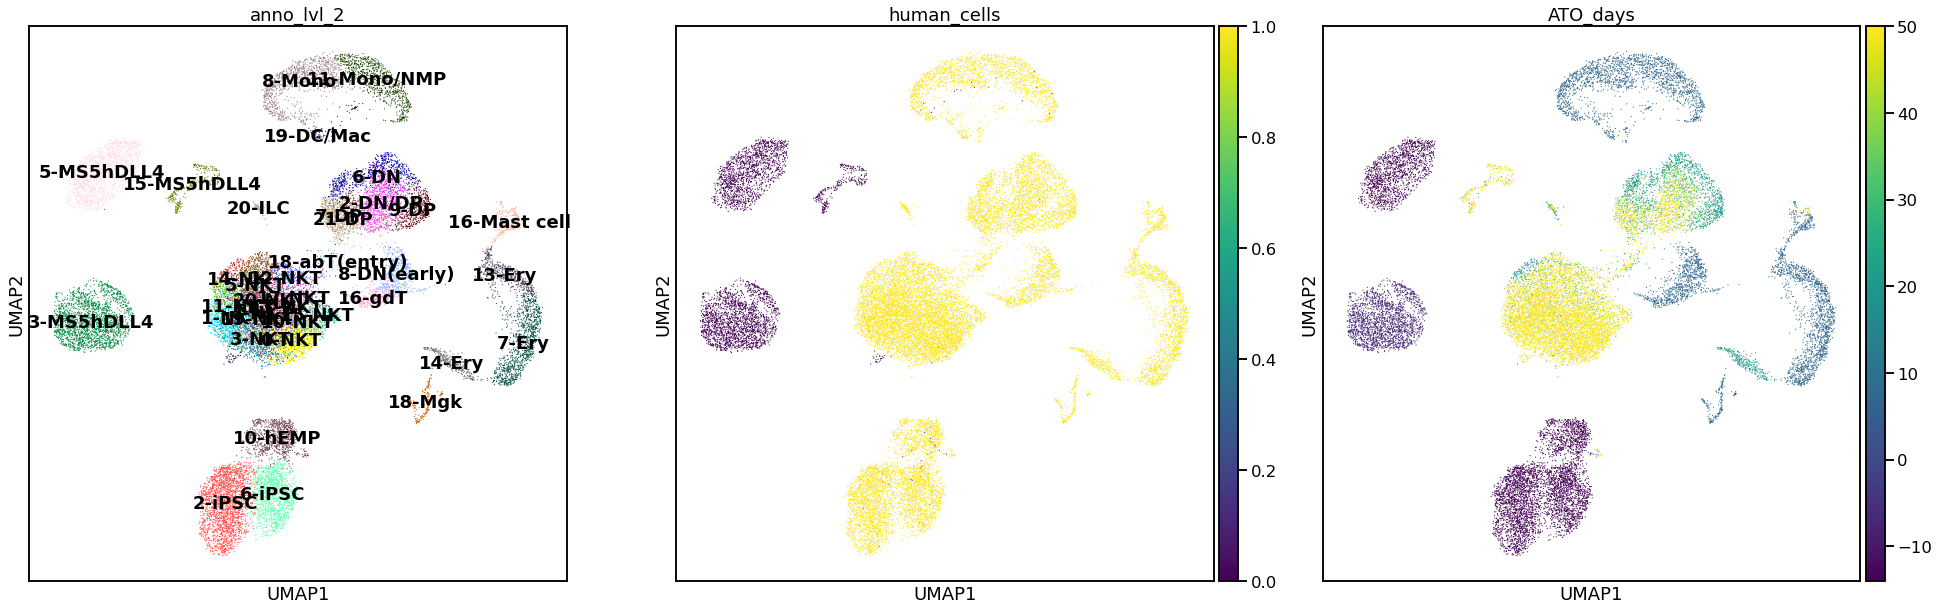

In [94]:
plt.rcParams["figure.figsize"] = [10,10]
ato_adata_cs42.obs["human_cells"] = ato_adata_cs42.obs["human_cells"].astype("int")
sc.pl.umap(ato_adata_cs42, color=["anno_lvl_2", "human_cells", 'ATO_days'], legend_loc='on data')


... storing 'anno_lvl_2_cs42' as categorical


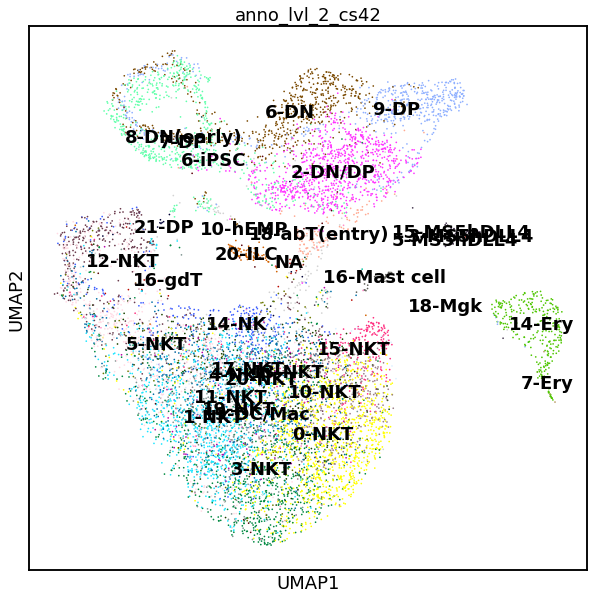

In [95]:
anno_df = ato_adata_cs42.obs.copy()
anno_df.index = ['_'.join([x[1] + "-1", x[0]]) for x in ato_adata_cs42.obs_names.str.split("-")]

ato_adata.obs['anno_lvl_2_cs42'] = [anno_df.loc[x]['anno_lvl_2'] if x in anno_df.index else np.nan for x in ato_adata.obs_names]

ato_adata_pp.obs['anno_lvl_2_cs42'] = ato_adata.obs['anno_lvl_2_cs42'].copy()

sc.pl.umap(ato_adata_pp, color='anno_lvl_2_cs42', legend_loc='on data')

# Train on scVI models

## Mapping 2 HSC_IMMUNE 

On GPU node, running the call:

We merge datasets and rerun embeddings running

### Load output

In [50]:
data_dir = '/nfs/team205/ed6/data/Fetal_immune/'

In [51]:
merged_adata_file = 'ATO_query.mapped2HSC_IMMUNE.withReference.h5ad'
split = "HSC_IMMUNE"
ref_data_dir = '/home/jovyan/mount/gdrive/Pan_fetal/data4gpu_node/'
timestamp = '20210429'

In [52]:
merged_adata = sc.read_h5ad(ref_data_dir + merged_adata_file)

In [53]:
## Filter maternal contaminants
mat_barcodes = pd.read_csv("~/Pan_fetal_immune/metadata/souporcell_results/maternal_barcodes.csv", index_col=0)
mat_barcodes = pd.Series([x.split("-1")[0] for x in mat_barcodes['x']])
reference_obs = merged_adata.obs_names[merged_adata.obs.dataset == "reference"]
exclude_obs = reference_obs[reference_obs.str.strip("-reference").isin(mat_barcodes)]

merged_adata = merged_adata[~merged_adata.obs_names.isin(exclude_obs)].copy()

In [282]:
## Add metadata and annotations for the reference
anno_obs = pd.read_csv(data_dir + "PAN.A01.v01.entire_data_normalised_log.20210429.full_obs.annotated.clean.csv", index_col=0)

## Read annotation groupings
import json
with open('../../metadata/anno_groups.json', 'r') as json_file:
    anno_groups_dict = json.load(json_file)
 

In [54]:
   
reference_obs = merged_adata.obs_names[merged_adata.obs.dataset == "reference"]

merged_adata.obs["annotation_reference"] = np.nan
merged_adata.obs.loc[reference_obs, "annotation_reference"] = anno_obs.loc[reference_obs.str.strip("-reference")]["anno_lvl_2_final_clean"].values

merged_adata.obs["organ"] = np.nan
merged_adata.obs.loc[reference_obs, "organ"] = anno_obs.loc[reference_obs.str.strip("-reference")]["organ"].values
merged_adata.obs["age"] = np.nan
merged_adata.obs.loc[reference_obs, "age"] = anno_obs.loc[reference_obs.str.strip("-reference")]["age"].values

In [57]:
## Add metadata and annotations for the query
query_obs = merged_adata.obs_names[merged_adata.obs.dataset == "query"]
merged_adata.obs["annotation_query"] = merged_adata.obs["anno_lvl_2_cs42"]

... storing 'annotation_reference' as categorical
... storing 'organ' as categorical


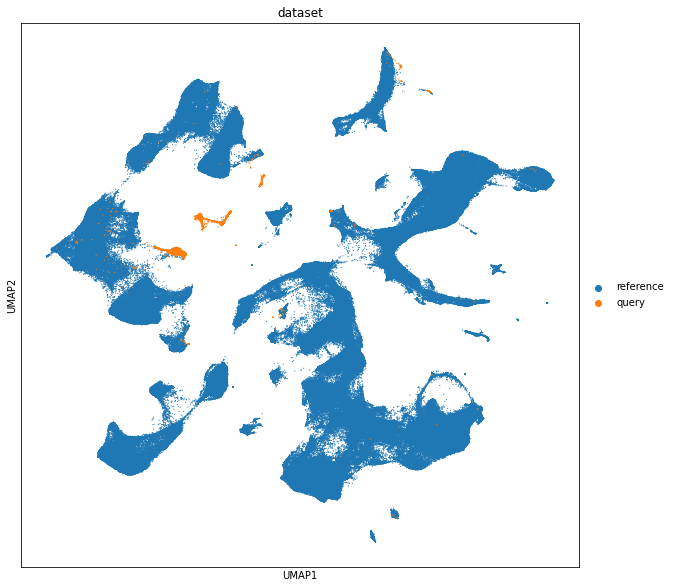

In [58]:
plt.rcParams["figure.figsize"] = [10,10]
sc.pl.umap(merged_adata, color=["dataset"], size=5)

### Plot query and reference annotations

saving figure to file /home/jovyan/mount/gdrive/Pan_fetal/Updates_and_presentations/figures/invivoVSinvitro/scvelo_anno_query.png


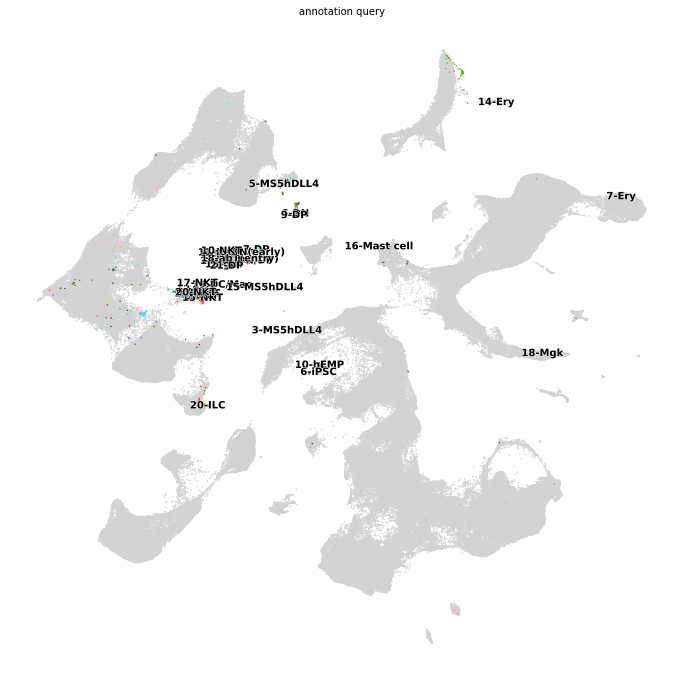

In [61]:
plt.rcParams['figure.figsize'] = [12,12]
anno_labels = merged_adata.obs["annotation_query"][merged_adata.obs["annotation_query"]!="nan"].unique().tolist()
scv.pl.umap(merged_adata, color=["annotation_query"], size=8, legend_loc="on data", groups=anno_labels, title="annotation query", legend_fontsize=10, 
            save="anno_query.png")

saving figure to file /home/jovyan/mount/gdrive/Pan_fetal/Updates_and_presentations/figures/invivoVSinvitro/scvelo_anno_reference.png


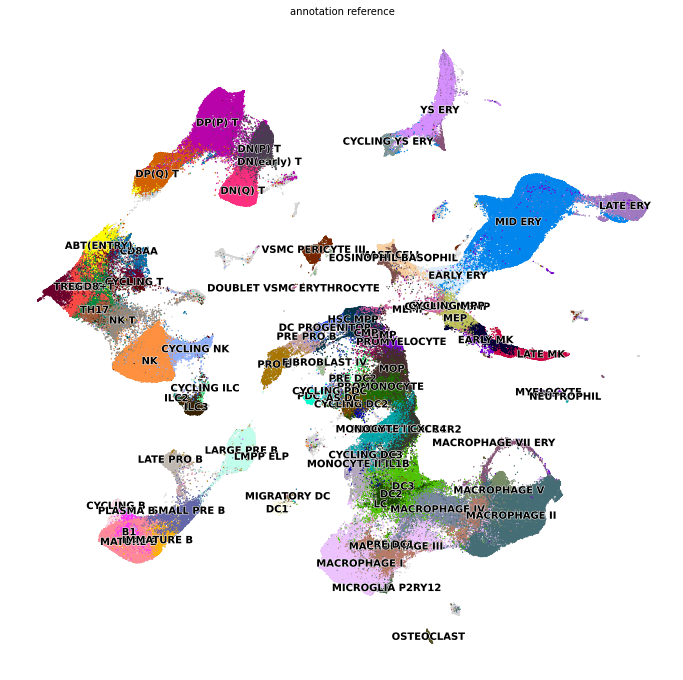

In [62]:
anno_labels = merged_adata.obs["annotation_reference"][merged_adata.obs["annotation_reference"]!="nan"].unique().tolist()
anno_labels = [x for x in anno_labels if type(x)==str]
anno_labels = [x for x in anno_labels if x not in anno_groups_dict["OTHER"]]

scv.pl.umap(merged_adata, color=["annotation_reference"], size=7, legend_loc="on data", groups=anno_labels, 
            legend_fontsize=10,
            title="annotation reference",
           save="anno_reference.png")

### Transfer labels

In [63]:
merged_adata.obs["annotation_reference"] = merged_adata.obs["annotation_reference"].astype("str").replace("nan", np.nan)
map_query_utils.predict_label(merged_adata, anno_col="annotation_reference")

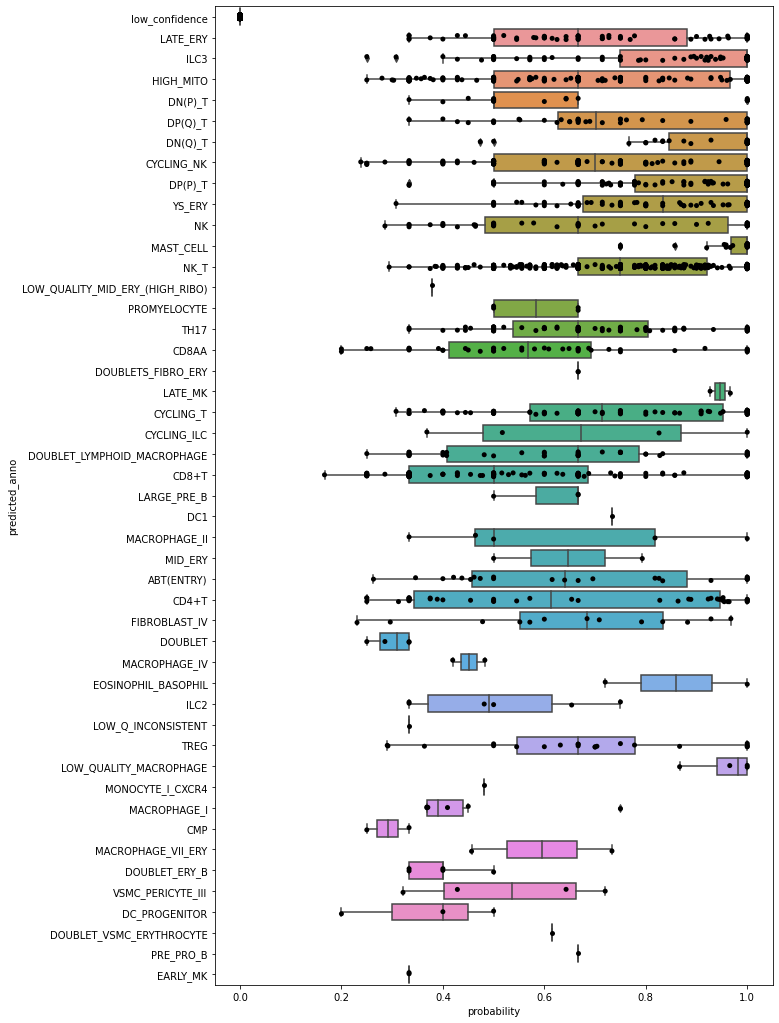

In [64]:
plt.rcParams["figure.figsize"] = [10,18]
map_query_utils.plot_predicted_anno_probability(merged_adata)

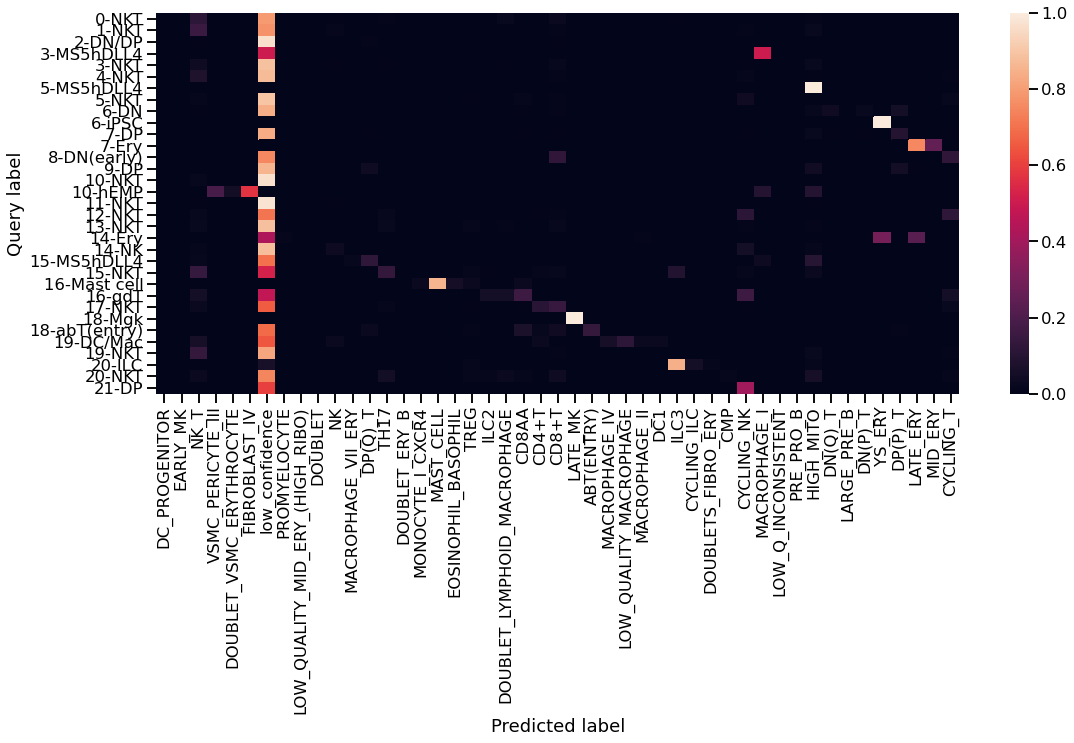

In [65]:
sns.set_context("talk")
query_anno_col="annotation_query"

query_obs = merged_adata.obs_names[merged_adata.obs.dataset == "query"]
empty_query = query_obs[merged_adata[query_obs].obs[query_anno_col]=="nan"]
merged_adata_clean = merged_adata[~merged_adata.obs_names.isin(empty_query)]

plt.rcParams["figure.figsize"] = [18,7]
map_query_utils.plot_confusion_mat(merged_adata_clean, query_anno_col=query_anno_col, show_low_confidence=True)
plt.savefig(figdir + "confusion_label_transfer.pdf", bbox_inches="tight")

### Quantify matching between datasets

In [66]:
import time
start = time.time()
mnn_query, mnn_ref = map_query_utils._find_MNNs(merged_adata)
end = time.time()
print(end - start)

17.468024969100952


In [67]:
map_query_utils._MNN_to_KNN_similarity_ratio(merged_adata, mnn_ref, mnn_query)

... storing 'annotation_reference' as categorical
... storing 'predicted_anno' as categorical


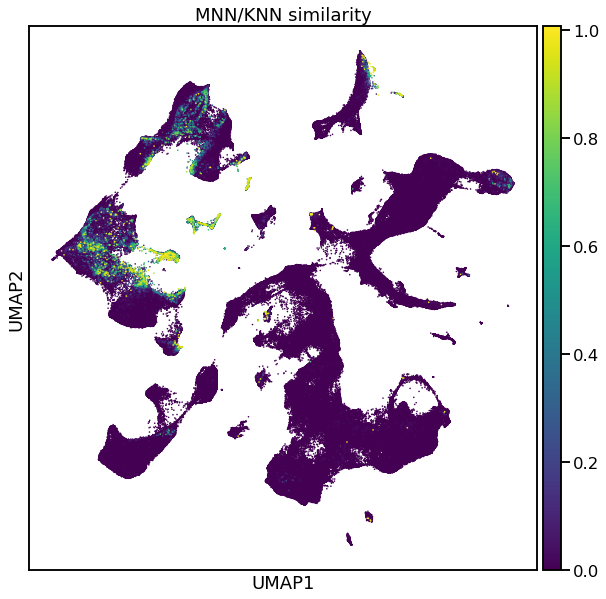

In [68]:
plt.rcParams["figure.figsize"] = [10,10]
sns.set_context("talk")
sc.pl.umap(merged_adata, color="mnn_sim_ratio", size=10, title="MNN/KNN similarity")

In [69]:
mpl.rcParams["figure.figsize"] = [15,4]
_plot_sorted_violin(merged_adata[merged_adata.obs.dataset=="query"], "annotation_query", "mnn_sim_ratio")
_plot_sorted_violin(merged_adata, "annotation_reference", "mnn_sim_ratio")

NameError: name 'mpl' is not defined

### Save outputs

In [ ]:
merged_adata.write_h5ad(data_dir + merged_adata_file)

### Combined similarity & confusion matrix

In [71]:
q_df = merged_adata[merged_adata.obs['dataset'] == 'query'].obs[["mnn_sim_ratio", "predicted_anno", "annotation_query"]]

In [283]:
query_anno_group_lymphoid = {
    "DP/DN":[x for x in q_df.annotation_query.unique() if 'DN' in x or 'DP' in x],
    "NKT cells":[x for x in q_df.annotation_query.unique() if x.endswith("NKT")],
    "NK cells":[x for x in q_df.annotation_query.unique() if x.endswith("NK")],
    'Erythroid cells':[x for x in q_df.annotation_query.unique() if x.endswith("Ery")],
    "Myeloid cells":[x for x in q_df.annotation_query.unique() if 'maso' in x or 'DC' in x or "Mac" in x]
#     "other":[x for x in q_df.annotation_query.unique() if 'doublets' in x],
    }

query_anno_group_lymphoid['other'] = [x for x in q_df.annotation_query.unique() if x not in sum(query_anno_group_lymphoid.values(),[])]
query_anno_group_lymphoid_rev = {x:g for g,a in query_anno_group_lymphoid.items() for x in a}

# ref_anno_group_lymphoid = {
#     "NK cells":[x for x in q_df.predicted_anno.unique() if x.endswith("NK")],
#     "ILCs":[x for x in q_df.predicted_anno.unique() if x.startswith("ILC")],
#     "B cells":[x for x in q_df.predicted_anno.unique() if x.endswith("B") or x=="B1"],
#     "T cells":[x for x in q_df.predicted_anno.unique() if x.endswith("T") or x=="ABT(ENTRY)" or x=="CD8AA"],
#     'low_confidence':['low_confidence']
#     }

ref_anno_group_lymphoid = anno_groups_dict.copy()
ref_anno_group_lymphoid['low_confidence'] = ['low_confidence']

ref_anno_group_lymphoid['other'] = [x for x in q_df.predicted_anno.unique() if x not in sum(ref_anno_group_lymphoid.values(),[])]
ref_anno_group_lymphoid_rev = {x:g for g,a in ref_anno_group_lymphoid.items() for x in a}

q_df['annotation_query_group'] = [query_anno_group_lymphoid_rev[x] for x in q_df['annotation_query']]
q_df['predicted_anno_group'] = [ref_anno_group_lymphoid_rev[x] for x in q_df['predicted_anno']]

`summarise()` has grouped output by 'predicted_anno', 'annotation_query', 'annotation_query_group', 'predicted_anno_group'. You can override using the `.groups` argument.


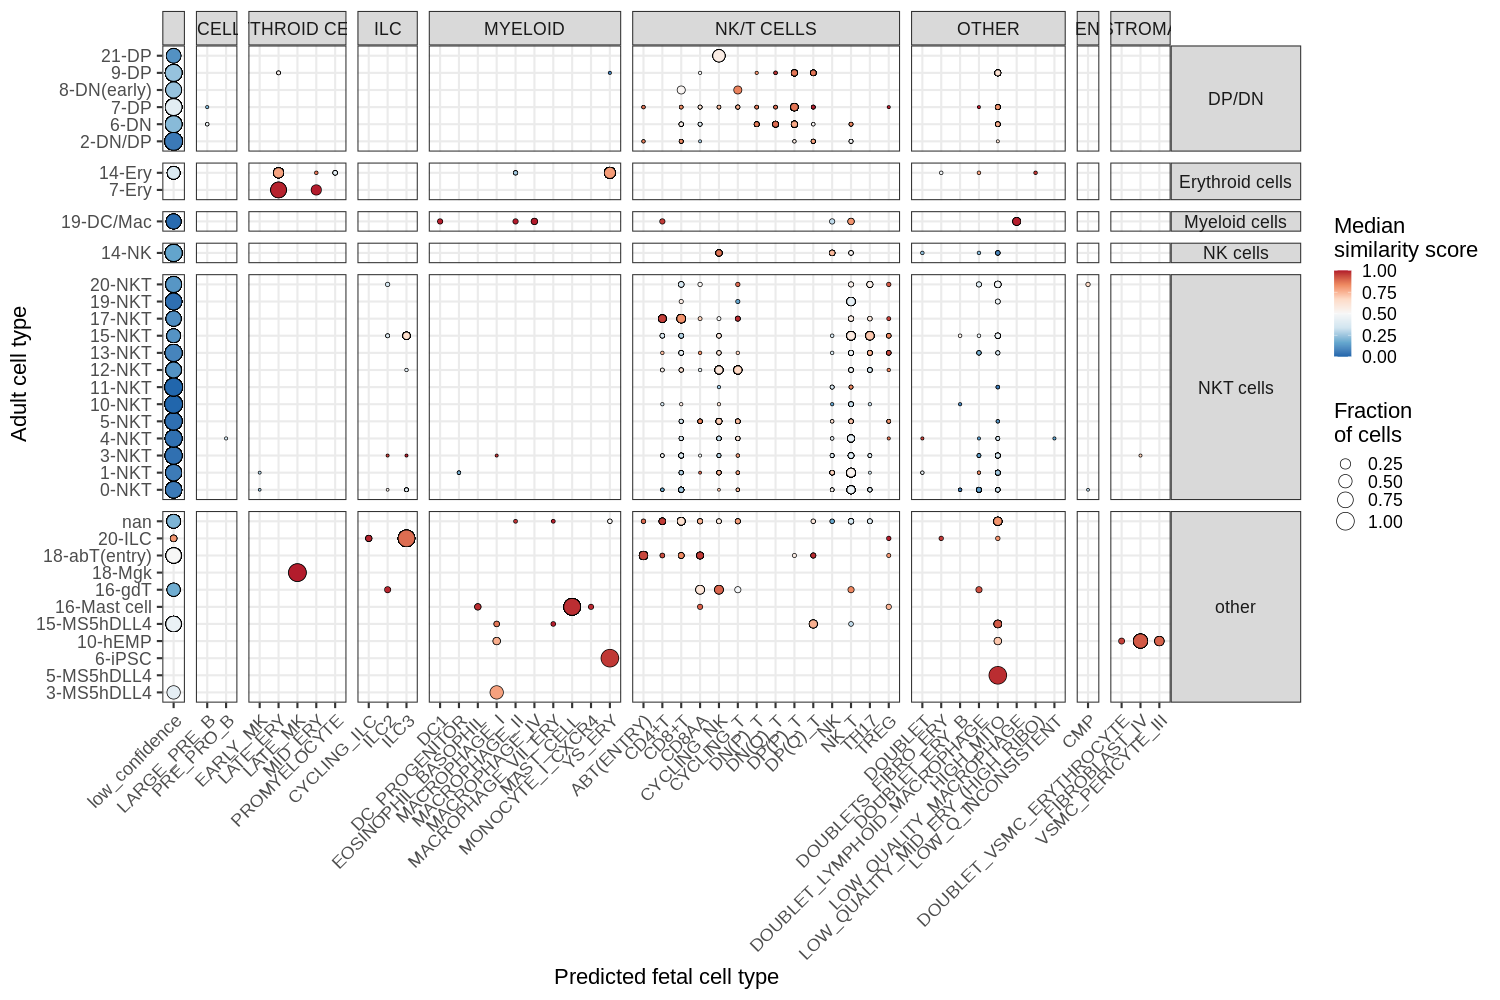

In [86]:
%%R -i q_df -h 1000 -w 1500 -i figdir
q_df %>%
    group_by(annotation_query) %>%
    mutate(tot_cells=n()) %>%
    ungroup() %>%
    group_by(predicted_anno, annotation_query, annotation_query_group, predicted_anno_group) %>%
    summarise(frac_cells=n()/tot_cells, median_sim_score=median(mnn_sim_ratio)) %>%
    ungroup() %>%
#     filter(annotation_query_group != 'other' & predicted_anno_group != 'other' ) %>%
#     mutate(annotation_query_group=factor(annotation_query_group, levels=c('NK cells', 'ILCs', 'B cells', 'T cells'))) %>%
    mutate(predicted_anno_group = ifelse(predicted_anno_group=="low_confidence", '', predicted_anno_group)) %>%
#     mutate(predicted_anno_group=factor(predicted_anno_group, levels=c('NK cells', 'ILCs', 'B cells', 'T cells', ''))) %>%
    ggplot(aes(predicted_anno, annotation_query)) +
    scale_size(range=c(1,8), name="Fraction\nof cells") +
    geom_point(aes(size=frac_cells, fill=median_sim_score), shape=21) +
    scale_fill_distiller(palette="RdBu", direction=-1, name='Median\nsimilarity score') +
    facet_grid(annotation_query_group~predicted_anno_group, space="free", scales='free') +
    xlab("Predicted fetal cell type") + ylab("Adult cell type") +
    theme_bw(base_size=22) +
    theme(axis.text.x=element_text(angle=45, hjust=1), strip.text.y=element_text(angle=0)) 
#     ggsave(paste0(figdir, "adult_confusion_similarity_dotplot.pdf"), width=15, height=10)

In [103]:
ato_adata_pp.var_names = ato_adata_pp.var['gene_names'].values

In [282]:
nkt_markers_dict['ABT(ENTRY)']

['CCR9', 'SATB1', 'TOX2']

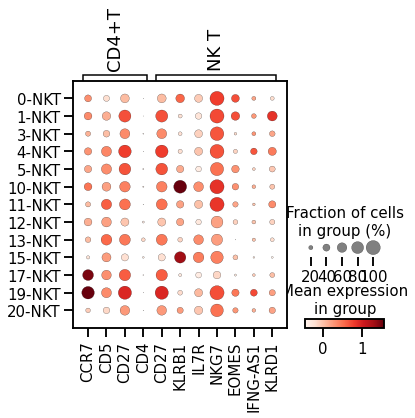

In [127]:
nkt_markers = pd.read_csv("../../metadata/marker_genes/NKT_marker_genes_09072021_clean.csv", index_col=0)
nkt_markers_dict = {ct:nkt_markers[nkt_markers['anno_lvl_2'] == ct]['gene'].tolist() for ct in nkt_markers['anno_lvl_2'].unique()}

cts_oi = ["CD4+T", "NK T"]

sc.pl.dotplot(ato_adata_pp[ato_adata_pp.obs['anno_lvl_2_cs42'].isin(query_anno_group_lymphoid['NKT cells'])], 
              {k:v for k,v in nkt_markers_dict.items() if k in cts_oi}, 
              groupby='anno_lvl_2_cs42')

## Mapping 2 lymphoid

### Load output

In [12]:
data_dir = '/nfs/team205/ed6/data/Fetal_immune/'

merged_adata_file = 'ATO_query.mapped2LYMPHOID.withReference.h5ad'
split = "LYMPHOID"
ref_data_dir = '/home/jovyan/mount/gdrive/Pan_fetal/data4gpu_node/'
timestamp = '20210429'

In [312]:
merged_adata_2 = sc.read_h5ad(ref_data_dir + merged_adata_file)

In [313]:
merged_adata = merged_adata_2.copy()

In [314]:
## Filter maternal contaminants
mat_barcodes = pd.read_csv("~/Pan_fetal_immune/metadata/souporcell_results/maternal_barcodes.csv", index_col=0)
mat_barcodes = pd.Series([x.split("-1")[0] for x in mat_barcodes['x']])
reference_obs = merged_adata.obs_names[merged_adata.obs.dataset == "reference"]
exclude_obs = reference_obs[reference_obs.str.strip("-reference").isin(mat_barcodes)]

merged_adata = merged_adata[~merged_adata.obs_names.isin(exclude_obs)].copy()

In [315]:
## Add metadata and annotations for the reference
anno_obs = pd.read_csv(data_dir + "PAN.A01.v01.entire_data_normalised_log.20210429.full_obs.annotated.clean.csv", index_col=0)

## Read annotation groupings
import json
with open('../../metadata/anno_groups.json', 'r') as json_file:
    anno_groups_dict = json.load(json_file)
    
reference_obs = merged_adata.obs_names[merged_adata.obs.dataset == "reference"]

merged_adata.obs["annotation_reference"] = np.nan
merged_adata.obs.loc[reference_obs, "annotation_reference"] = anno_obs.loc[reference_obs.str.strip("-reference")]["anno_lvl_2_final_clean"].values

merged_adata.obs["organ"] = np.nan
merged_adata.obs.loc[reference_obs, "organ"] = anno_obs.loc[reference_obs.str.strip("-reference")]["organ"].values
merged_adata.obs["age"] = np.nan
merged_adata.obs.loc[reference_obs, "age"] = anno_obs.loc[reference_obs.str.strip("-reference")]["age"].values

In [316]:
## Add metadata and annotations for the query
query_obs = merged_adata.obs_names[merged_adata.obs.dataset == "query"]
merged_adata.obs["annotation_query"] = merged_adata.obs["anno_lvl_2_cs42"]

... storing 'annotation_reference' as categorical
... storing 'organ' as categorical


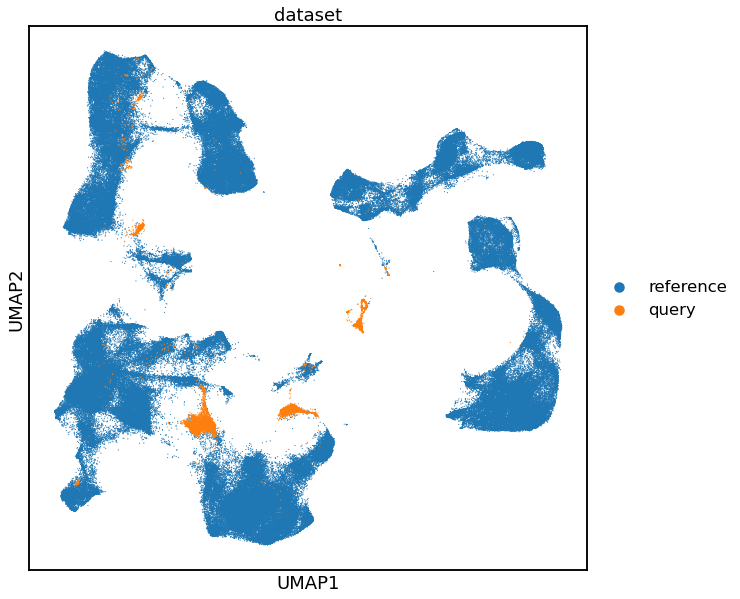

In [317]:
plt.rcParams["figure.figsize"] = [10,10]
sc.pl.umap(merged_adata, color=["dataset"], size=5)

### Plot query and reference annotations

In [580]:
plt.rcParams['figure.figsize'] = [12,12]
anno_labels = merged_adata.obs["annotation_query"][~merged_adata.obs["annotation_query"].isna()].unique().tolist()
anno_labels

['ERY', 'DN/DP', 'ILC3', 'NK', 'HIGH_MITO', 'ABT(ENTRY)', 'SP_T', 'MAST CELL']

saving figure to file /home/jovyan/mount/gdrive/Pan_fetal/Updates_and_presentations/figures/invivoVSinvitro/scvelo_anno_query_lymphoid.png


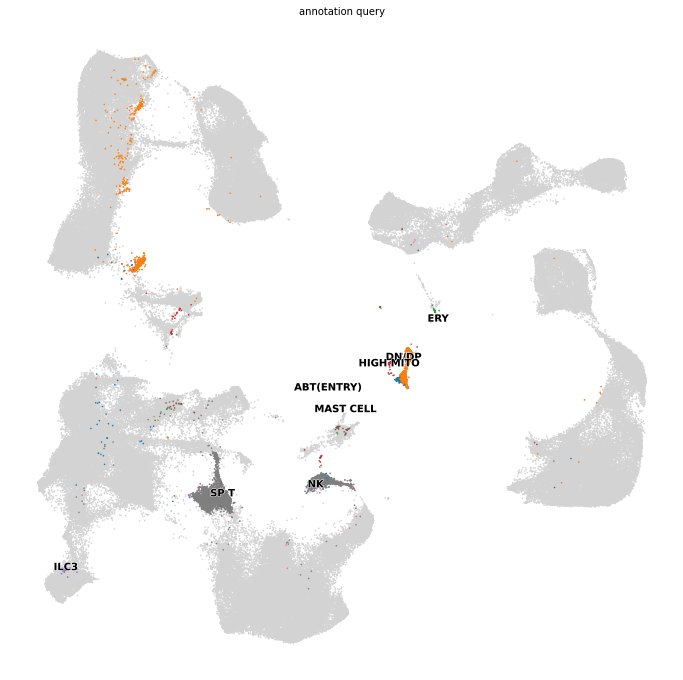

In [582]:
scv.pl.umap(merged_adata, color=["annotation_query"], size=10, legend_loc="on data", groups=anno_labels, title="annotation query", legend_fontsize=10, 
            save="anno_query_lymphoid.png")

saving figure to file /home/jovyan/mount/gdrive/Pan_fetal/Updates_and_presentations/figures/invivoVSinvitro/scvelo_anno_reference_lymphoid.png


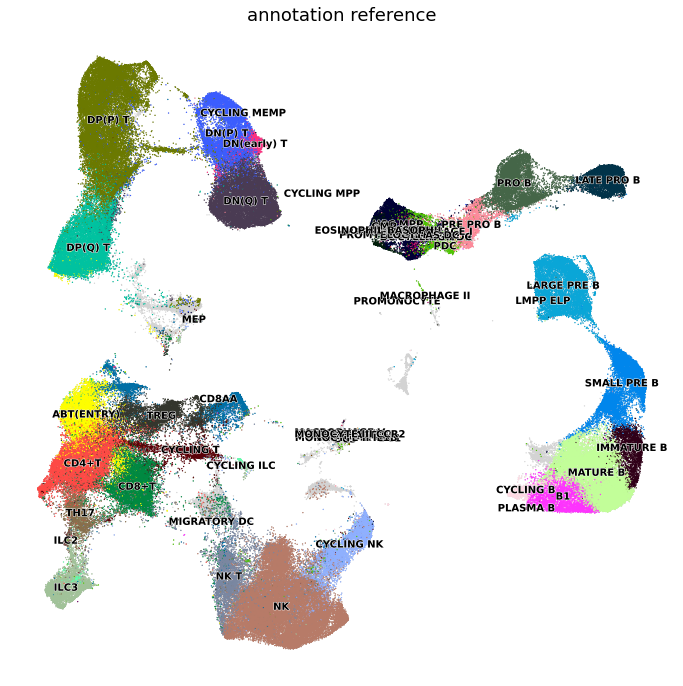

In [291]:
anno_labels = merged_adata.obs["annotation_reference"][merged_adata.obs["annotation_reference"]!="nan"].unique().tolist()
anno_labels = [x for x in anno_labels if type(x)==str]
anno_labels = [x for x in anno_labels if x not in anno_groups_dict["OTHER"]]

scv.pl.umap(merged_adata, color=["annotation_reference"], size=7, legend_loc="on data", groups=anno_labels, 
            legend_fontsize=10,
            title="annotation reference",
           save="anno_reference_lymphoid.png")

### Transfer labels

In [292]:
help(map_query_utils.predict_label)

Help on function predict_label in module map_query_utils:

predict_label(adata, anno_col, neighbors_key='connectivities', min_score=0)



In [293]:
merged_adata.obs["annotation_reference"] = merged_adata.obs["annotation_reference"].astype("str").replace("nan", np.nan)
map_query_utils.predict_label(merged_adata, anno_col="annotation_reference")

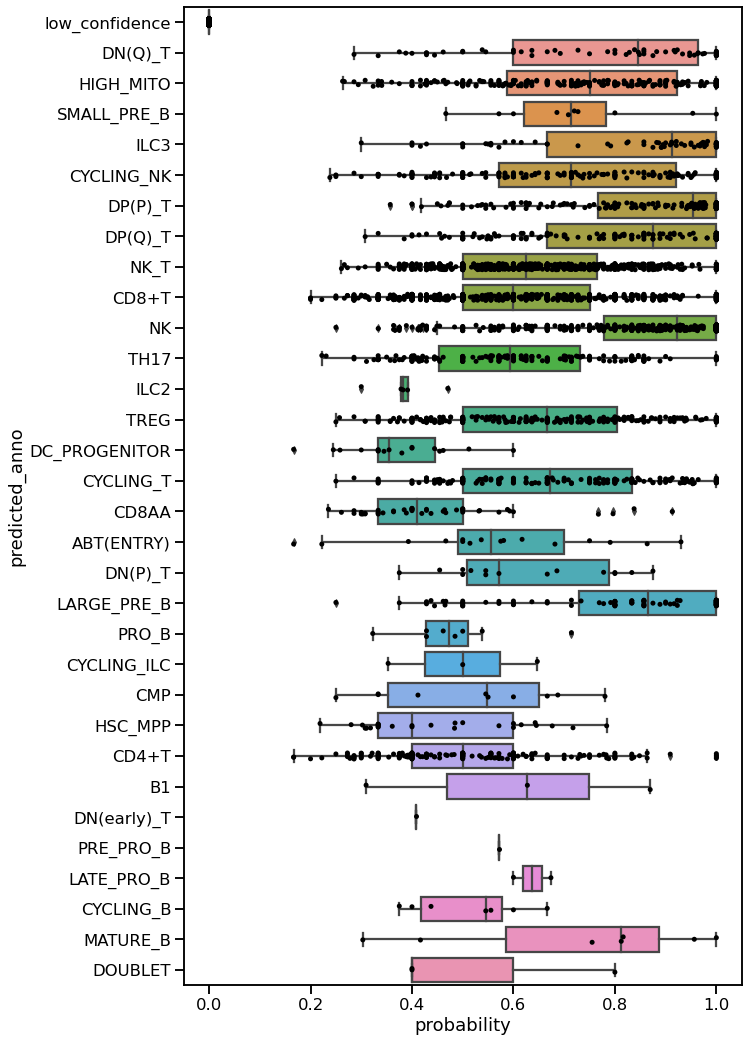

In [294]:
plt.rcParams["figure.figsize"] = [10,18]
map_query_utils.plot_predicted_anno_probability(merged_adata)

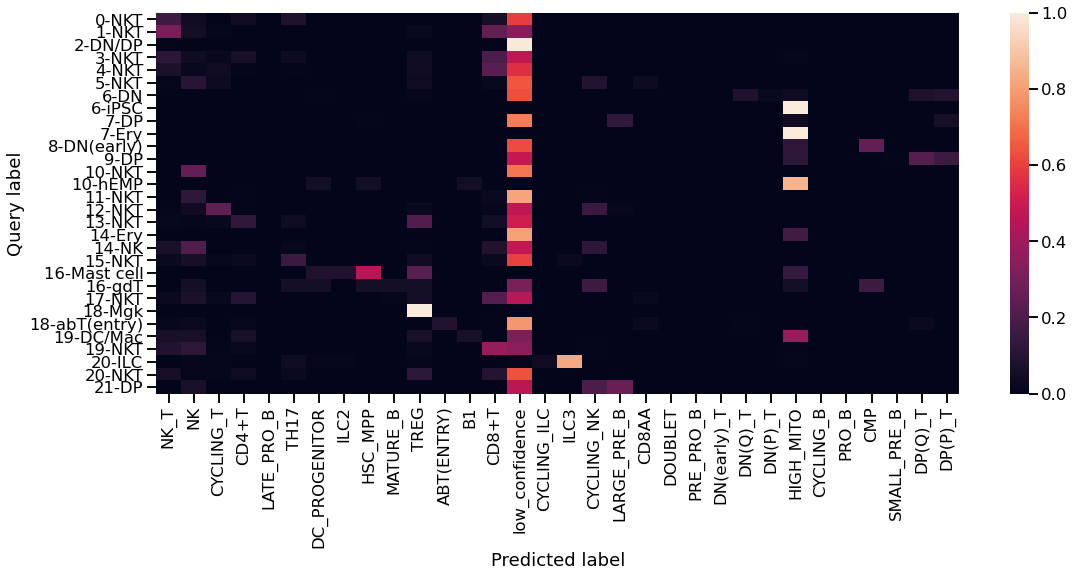

In [295]:
sns.set_context("talk")
query_anno_col="annotation_query"

query_obs = merged_adata.obs_names[merged_adata.obs.dataset == "query"]
empty_query = query_obs[merged_adata[query_obs].obs[query_anno_col]=="nan"]
merged_adata_clean = merged_adata[~merged_adata.obs_names.isin(empty_query)]

plt.rcParams["figure.figsize"] = [18,7]
map_query_utils.plot_confusion_mat(merged_adata_clean, query_anno_col=query_anno_col, show_low_confidence=True)
plt.savefig(figdir + "confusion_label_transfer_lymphoid.pdf", bbox_inches="tight")

### Quantify matching between datasets

In [296]:
import time
start = time.time()
mnn_query, mnn_ref = map_query_utils._find_MNNs(merged_adata)
end = time.time()
print(end - start)

17.04770588874817


In [297]:
map_query_utils._MNN_to_KNN_similarity_ratio(merged_adata, mnn_ref, mnn_query)

... storing 'annotation_reference' as categorical
... storing 'predicted_anno' as categorical


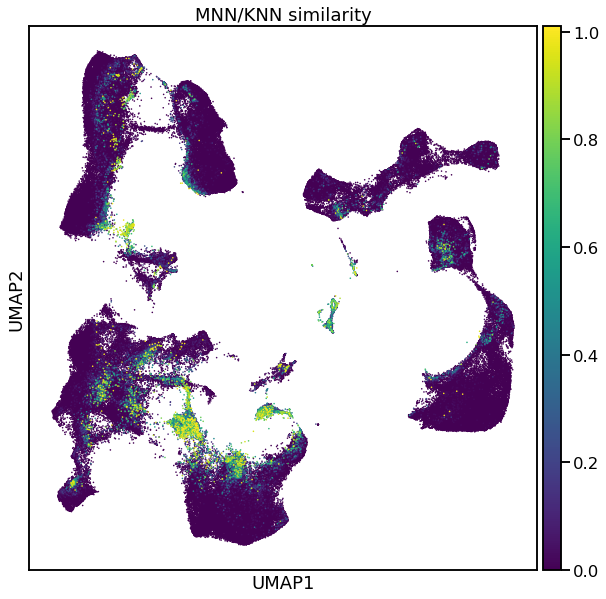

In [298]:
plt.rcParams["figure.figsize"] = [10,10]
sns.set_context("talk")
sc.pl.umap(merged_adata, color="mnn_sim_ratio", size=10, title="MNN/KNN similarity")

### Save outputs

In [11]:
data_dir + merged_adata_file

NameError: name 'data_dir' is not defined

In [300]:
merged_adata.write_h5ad(data_dir + merged_adata_file)

In [13]:
merged_adata = sc.read_h5ad(data_dir + merged_adata_file)

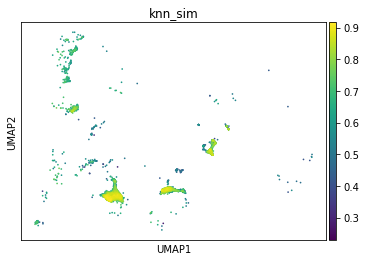

In [19]:
sc.pl.umap(merged_adata[merged_adata.obs['dataset']=='query'], color='knn_sim')

### Combined similarity & confusion matrix

In [560]:
q_df = merged_adata[merged_adata.obs['dataset'] == 'query'].obs[["mnn_sim_ratio", "predicted_anno", "annotation_query"]]

In [561]:
query_anno_group_lymphoid = {
    "DP/DN":[x for x in q_df.annotation_query.unique() if 'DN' in x or 'DP' in x],
    "NKT cells":[x for x in q_df.annotation_query.unique() if x.endswith("NKT")],
    "NK cells":[x for x in q_df.annotation_query.unique() if x.endswith("NK")],
    'Erythroid cells':[x for x in q_df.annotation_query.unique() if x.endswith("Ery")],
    "Myeloid cells":[x for x in q_df.annotation_query.unique() if 'maso' in x or 'DC' in x or "Mac" in x]
#     "other":[x for x in q_df.annotation_query.unique() if 'doublets' in x],
    }

query_anno_group_lymphoid['other'] = [x for x in q_df.annotation_query.unique() if x not in sum(query_anno_group_lymphoid.values(),[])]
query_anno_group_lymphoid_rev = {x:g for g,a in query_anno_group_lymphoid.items() for x in a}

ref_anno_group_lymphoid = {
    "NK cells":[x for x in q_df.predicted_anno.unique() if x.endswith("NK")],
    "ILCs":[x for x in q_df.predicted_anno.unique() if x.startswith("ILC")],
    "B cells":[x for x in q_df.predicted_anno.unique() if x.endswith("B") or x=="B1"],
    "T cells":[x for x in q_df.predicted_anno.unique() if x.endswith("T") or x=="ABT(ENTRY)" or x=="CD8AA"],
    'low_confidence':['low_confidence']
    }

# ref_anno_group_lymphoid = anno_groups_dict.copy()
# ref_anno_group_lymphoid['low_confidence'] = ['low_confidence']

ref_anno_group_lymphoid['other'] = [x for x in q_df.predicted_anno.unique() if x not in sum(ref_anno_group_lymphoid.values(),[])]
ref_anno_group_lymphoid_rev = {x:g for g,a in ref_anno_group_lymphoid.items() for x in a}

q_df['annotation_query_group'] = [query_anno_group_lymphoid_rev[x] for x in q_df['annotation_query']]
q_df['predicted_anno_group'] = [ref_anno_group_lymphoid_rev[x] for x in q_df['predicted_anno']]

`summarise()` has grouped output by 'predicted_anno', 'annotation_query', 'annotation_query_group', 'predicted_anno_group'. You can override using the `.groups` argument.


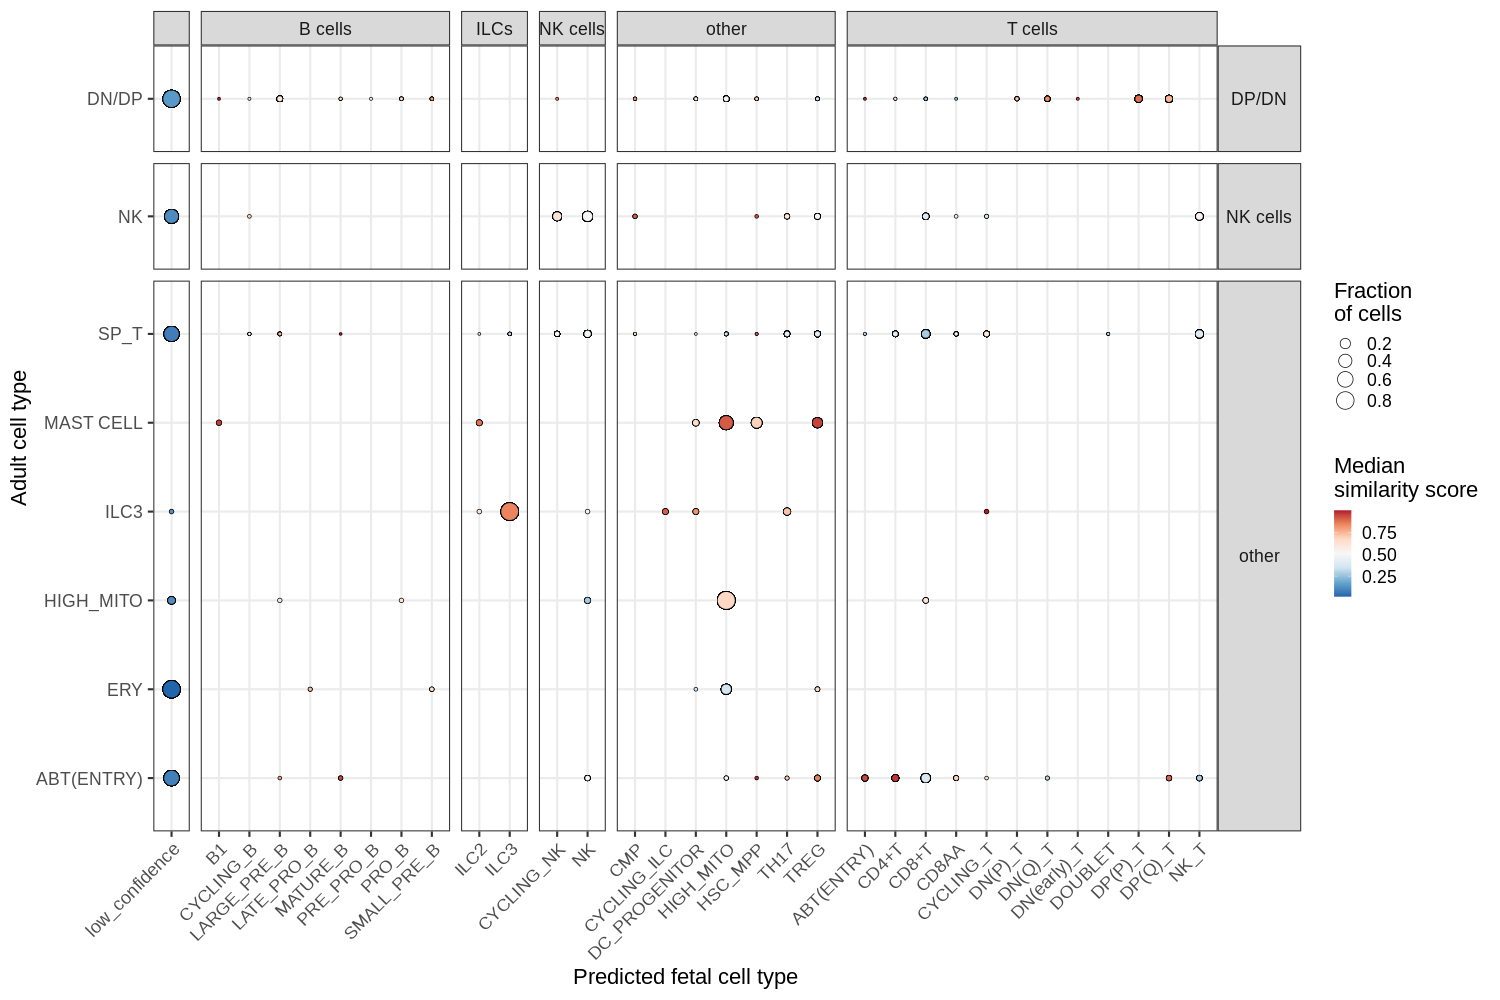

In [562]:
%%R -i q_df -h 1000 -w 1500 -i figdir
q_df %>%
    group_by(annotation_query) %>%
    mutate(tot_cells=n()) %>%
    ungroup() %>%
    group_by(predicted_anno, annotation_query, annotation_query_group, predicted_anno_group) %>%
    summarise(frac_cells=n()/tot_cells, median_sim_score=median(mnn_sim_ratio)) %>%
    ungroup() %>%
#     filter(annotation_query_group != 'other' & predicted_anno_group != 'other' ) %>%
#     mutate(annotation_query_group=factor(annotation_query_group, levels=c('NK cells', 'ILCs', 'B cells', 'T cells'))) %>%
    mutate(predicted_anno_group = ifelse(predicted_anno_group=="low_confidence", '', predicted_anno_group)) %>%
#     mutate(predicted_anno_group=factor(predicted_anno_group, levels=c('NK cells', 'ILCs', 'B cells', 'T cells', ''))) %>%
    ggplot(aes(predicted_anno, annotation_query)) +
    scale_size(range=c(1,8), name="Fraction\nof cells") +
    geom_point(aes(size=frac_cells, fill=median_sim_score), shape=21) +
    scale_fill_distiller(palette="RdBu", direction=-1, name='Median\nsimilarity score') +
    facet_grid(annotation_query_group~predicted_anno_group, space="free", scales='free') +
    xlab("Predicted fetal cell type") + ylab("Adult cell type") +
    theme_bw(base_size=22) +
    theme(axis.text.x=element_text(angle=45, hjust=1), strip.text.y=element_text(angle=0)) 
#     ggsave(paste0(figdir, "adult_confusion_similarity_dotplot.pdf"), width=15, height=10)

## Visualize results on ATO embedding

In [23]:
ato_adata = sc.read_h5ad('/nfs/team205/ed6/data/Fetal_immune/ATO_query.scVI.h5ad')

In [27]:
sc.pp.normalize_per_cell(ato_adata,counts_per_cell_after=10e4)
sc.pp.log1p(ato_adata)

In [30]:
ato_adata.obs['predicted_anno'] = merged_adata.obs.loc[ato_adata.obs_names + "-query", 'predicted_anno'].values
ato_adata.obs['similarity_knn'] = merged_adata.obs.loc[ato_adata.obs_names + "-query", 'knn_sim'].values
ato_adata.obs['similarity_score'] = merged_adata.obs.loc[ato_adata.obs_names + "-query", 'mnn_sim_ratio'].values

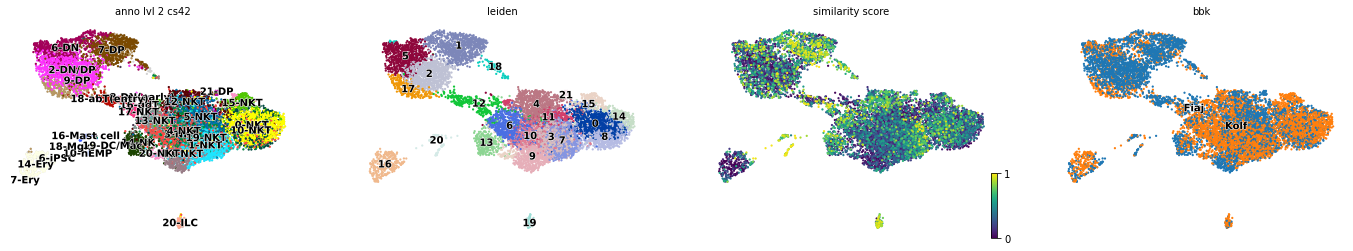

In [248]:
scv.pl.umap(ato_adata, color=['anno_lvl_2_cs42','leiden', 'similarity_score', 'bbk'], legend_loc='on data', size=20)

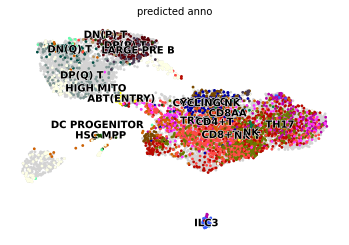

In [32]:
keep_anno = ato_adata.obs['predicted_anno'].value_counts()[1:][ato_adata.obs['predicted_anno'].value_counts()[1:] > 10].index.tolist()
scv.pl.umap(ato_adata, color=['predicted_anno'], legend_loc='on data', size=30, groups=keep_anno)

### Compute similarity to _in vivo_ SP states 

In [270]:
## Read annotation by Chenqu
ato_anno_df = pd.read_csv('/lustre/scratch117/cellgen/team205/cs42/panfetal/ATO_anno_lvl_1.csv', index_col=0)
ato_anno_df.index.isin(ato_adata.obs_names).all()

ato_adata.obs['anno_lvl_1_cs42'] = ato_anno_df['anno_lvl_1']
ato_adata.obs['anno_lvl_1_cs42']

In [273]:
ato_adata.obs_names = ato_adata.obs_names + "-query"

In [274]:
## Add annotation to merge
query_obs = merged_adata.obs_names[merged_adata.obs.dataset == "query"]
merged_adata.obs["annotation_query"] = ato_adata.obs["anno_lvl_1_cs42"]

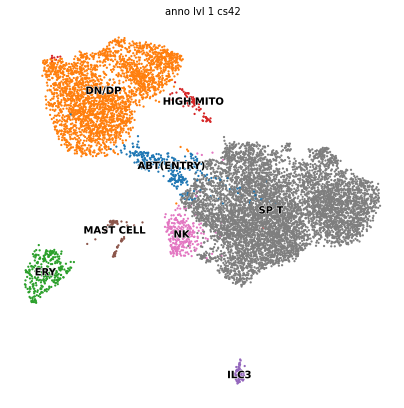

In [584]:
scv.pl.umap(ato_adata, color=['anno_lvl_1_cs42'], legend_loc='on data', size=20)

In [609]:
merged_adata.obs['plotting_annos'] = np.nan
merged_adata.obs.loc[merged_adata.obs['annotation_query'] == 'SP_T', 'plotting_annos'] = 'in vitro\nSP_T'
merged_adata.obs.loc[merged_adata.obs['annotation_reference'] == 'CD8+T', 'plotting_annos'] = 'in vivo\nCD8+T'
merged_adata.obs.loc[merged_adata.obs['annotation_reference'] == 'CD4+T', 'plotting_annos'] = 'in vivo\nCD4+T'
merged_adata.obs.loc[merged_adata.obs['annotation_reference'] == 'NK_T', 'plotting_annos'] = 'in vivo\nNK_T'

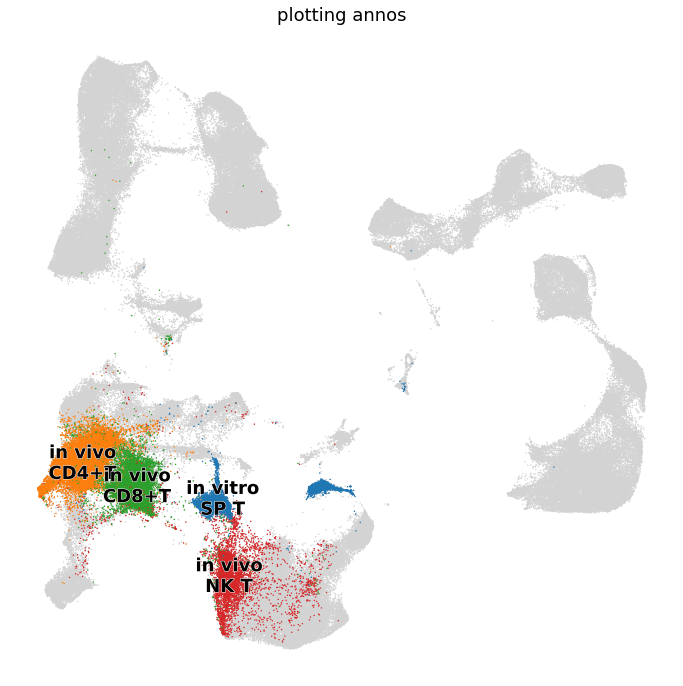

In [611]:
plt.rcParams['figure.figsize'] = [12,12]
sns.set_context("talk")
scv.pl.umap(merged_adata, color=["plotting_annos"], size=8, legend_loc="on data")
# scv.pl.umap(merged_adata, color=["annotation_reference"], size=4, legend_loc="on data", groups=['NK_T', "CD8+T", "CD4+T"])

In [441]:
merged_adata.var_names = merged_adata.var["GeneName"].values

In [444]:
sc.pp.normalize_per_cell(merged_adata, counts_per_cell_after=10e4)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [445]:
sc.pp.log1p(merged_adata)

In [577]:
ato_adata.var_names = ato_adata.var["gene_names"].values

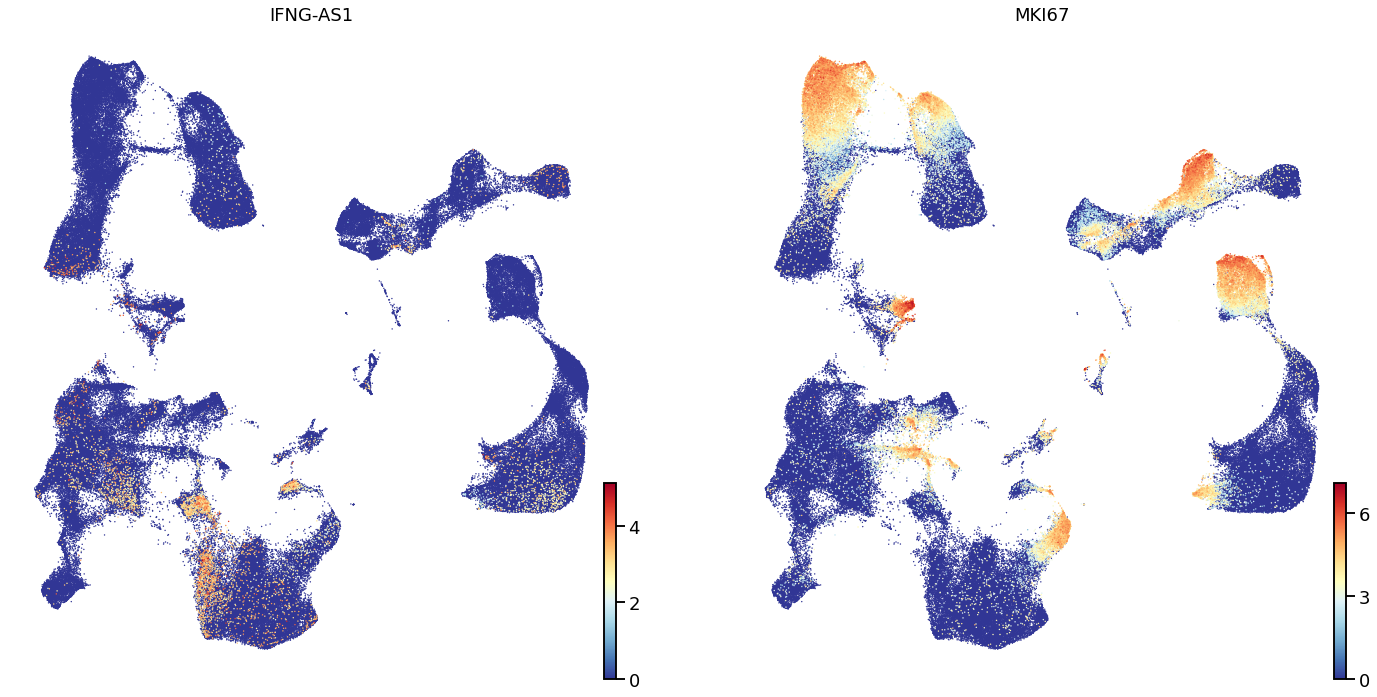

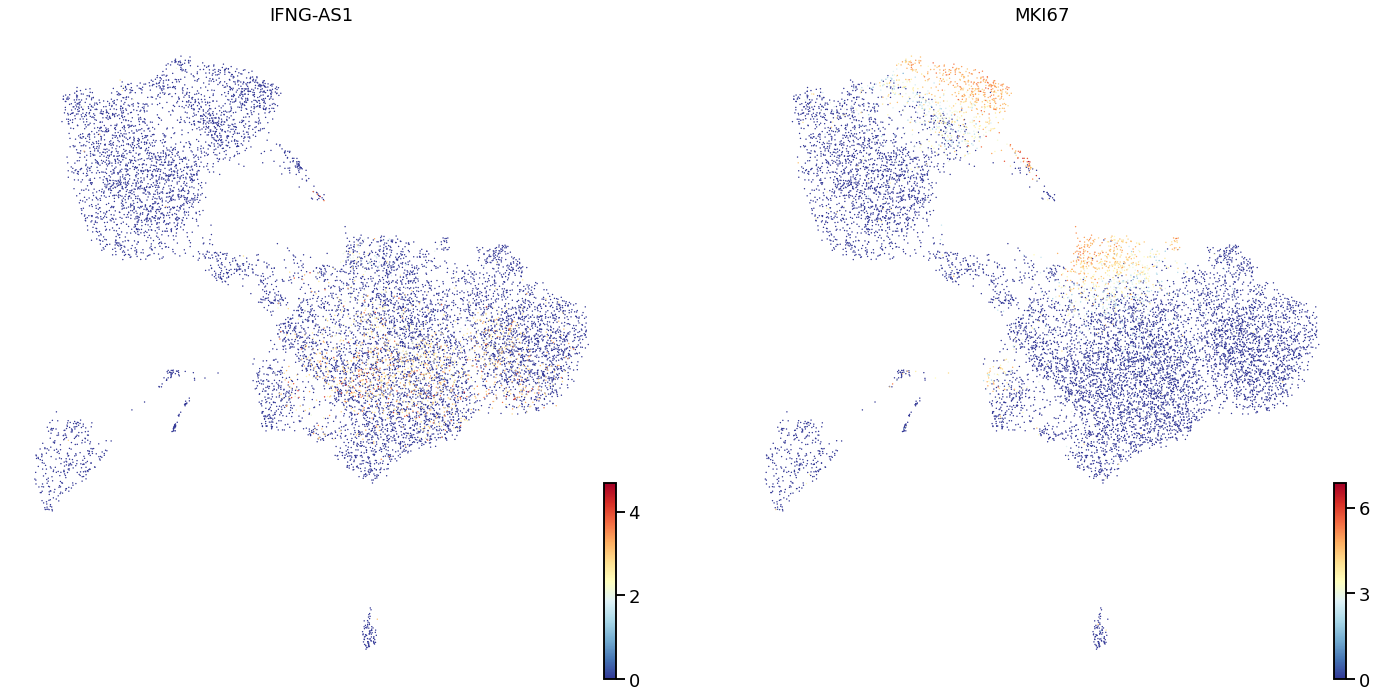

In [623]:
scv.pl.umap(merged_adata, color=["IFNG-AS1", "MKI67"], size=8, cmap="RdYlBu_r")
scv.pl.umap(ato_adata, color=["IFNG-AS1", "MKI67"], size=8, cmap="RdYlBu_r")

In [538]:
def _compute_invivoVSinvitro_distance(merged_adata, 
                                      q_cl, ## query cluster
                                      r_cl, ## reference cluster
                                      q_obs = 'annotation_query',
                                      r_obs = 'annotation_reference',
                                     ):
    keep_invitro_cells = (merged_adata.obs['dataset'] == 'query') & (merged_adata.obs[q_obs] == q_cl)
    keep_invivo_cells = (merged_adata.obs['dataset'] == 'reference') & (merged_adata.obs[r_obs] == r_cl)

    X_dims = merged_adata.obsm['X_scvi'].copy()
    X_dims_invivo = X_dims[keep_invivo_cells,:]
    X_dims_invitro = X_dims[keep_invitro_cells,:]
    dmat = scipy.spatial.distance.cdist( X_dims_invitro, X_dims_invivo, metric='euclidean')
    min_dist = np.min(dmat, 1)
    min_dist = map_query_utils._scArches_adjusted_dist(min_dist)
    min_dist_df = pd.DataFrame(min_dist, columns=['min_dist'])
    min_dist_df['ref_population'] = r_cl
    min_dist_df['query_population'] = q_cl 
    min_dist_df['cell_barcode'] = merged_adata.obs_names[keep_invitro_cells]
    return(min_dist_df)

def _compute_within_distance(merged_adata, 
                                      q_cl, ## query cluster
                                      q_obs = 'annotation_query',
                                     ):
    keep_invitro_cells = (merged_adata.obs['dataset'] == 'query') & (merged_adata.obs[q_obs] == q_cl)
    X_dims = merged_adata.obsm['X_scvi'].copy()
    X_dims_invitro = X_dims[keep_invitro_cells,:]
    mean_dist = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(X_dims_invitro, metric='cosine')).min()
    return(mean_dist)

In [542]:
ref_cts = ref_anno_group_lymphoid['NK/T CELLS']
que_cts = merged_adata.obs["annotation_query"].unique().dropna()

ct_distances_df = pd.DataFrame()
for r in ref_cts:
    for q in que_cts:
        d = _compute_invivoVSinvitro_distance(merged_adata, q_cl=q, r_cl=r)
        ct_distances_df = pd.concat([ct_distances_df, d])

In [543]:
ct_distances_df = ct_distances_df.dropna()

In [544]:
%%R -i ct_distances_df -w 600 -h 500
ct_distances_df_pl <- ct_distances_df %>%
#     mutate(min_dist=1/(1+min_dist)) %>%
    group_by(query_population, ref_population) %>%
    mutate(mean_min_dist = median(min_dist)) %>%
    ungroup() %>%
    group_by(query_population) %>%
    mutate(ref_pop_order= dense_rank(mean_min_dist)) %>%
    ungroup() 
    

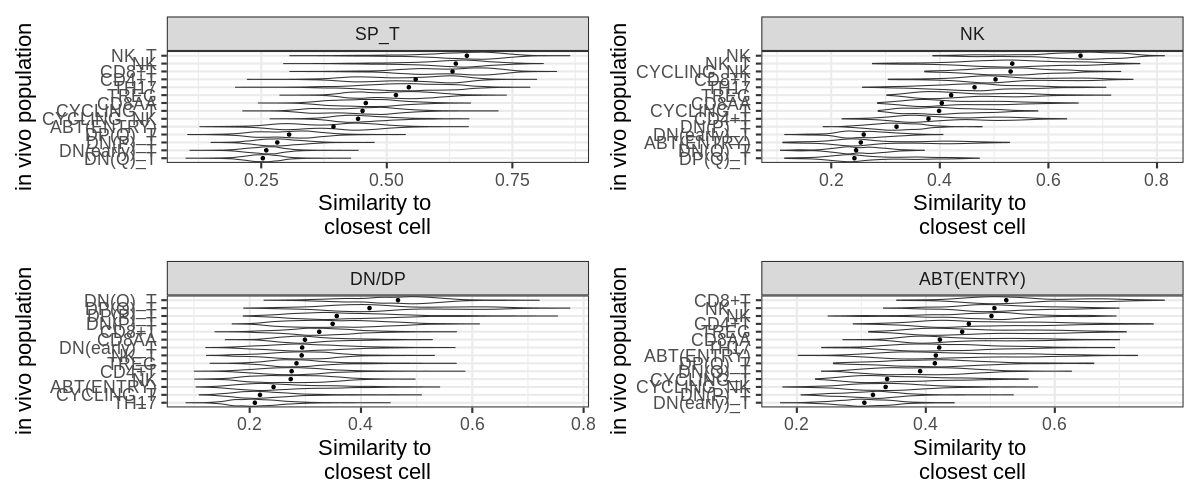

In [626]:
%%R -w 1200 -h 500

plot_q_pop_distance <- function(q_pop, top_n_pops=NULL){
    if (is.null(top_n_pops)){
        top_n_pops <- min(as.numeric(ct_distances_df_pl$ref_pop_order))
    }
    ct_distances_df_pl %>%
    filter(query_population==q_pop) %>%
    filter(ref_pop_order > top_n_pops) %>%
    arrange(ref_pop_order) %>%
    mutate(ref_population=factor(ref_population, levels=unique(ref_population))) %>%
    ggplot(aes(ref_population, min_dist)) +
    geom_violin(scale='width', adjust = .8) +
    geom_point(data=. %>% group_by(ref_population) %>% summarise(mean_min_dist=first(mean_min_dist)), 
               aes(y=mean_min_dist)) +
    facet_wrap(.~query_population) +
    coord_flip() +
    theme_bw(base_size=22) +
    ylab("Similarity to \nclosest cell") +
    xlab("in vivo population") 

}

plot_q_pop_distance('SP_T') +
plot_q_pop_distance('NK') +
plot_q_pop_distance('DN/DP') +
plot_q_pop_distance('ABT(ENTRY)') +
ggsave(paste0(figdir, "similarity_violins.pdf"), width=12, height=8)
# max(as.numeric(ct_distances_df_pl$ref_pop_order))

In [474]:
%%R
ct_distances_df_pl %>%
    filter(query_population=="SP_T") %>%
    head()

   min_dist ref_population query_population
1 0.1827113      CYCLING_T             SP_T
2 0.1727491      CYCLING_T             SP_T
3 0.3187751      CYCLING_T             SP_T
4 0.1415104      CYCLING_T             SP_T
5 0.3916585      CYCLING_T             SP_T
6 0.1647778      CYCLING_T             SP_T
                              cell_barcode mean_min_dist ref_pop_order
1 AACCGCGAGCGCTTAT-1_6180STDY9448808-query     0.2349941             7
2 AATCCAGCATGCTGGC-1_6180STDY9448808-query     0.2349941             7
3 ACAGCTACATGGATGG-1_6180STDY9448808-query     0.2349941             7
4 ACGGCCATCAGCATGT-1_6180STDY9448808-query     0.2349941             7
5 ACTGAGTCATCCCACT-1_6180STDY9448808-query     0.2349941             7
6 ACTTTCAAGGGTGTGT-1_6180STDY9448808-query     0.2349941             7


In [627]:
ct_distances_df_wide = ct_distances_df.pivot(index='cell_barcode', columns='ref_population', values='min_dist')

# ct_distances_df_wide = scipy.special.softmax(ct_distances_df_wide, axis=1)

In [628]:
ato_adata.obs['closest_cell'] = ct_distances_df_wide.idxmax(1)

In [629]:
ato_adata.obs = ato_adata.obs.drop(ct_distances_df_wide.columns, 1)

In [630]:
ato_adata.obs = pd.concat([ato_adata.obs, ct_distances_df_wide], 1)

... storing 'closest_cell' as categorical


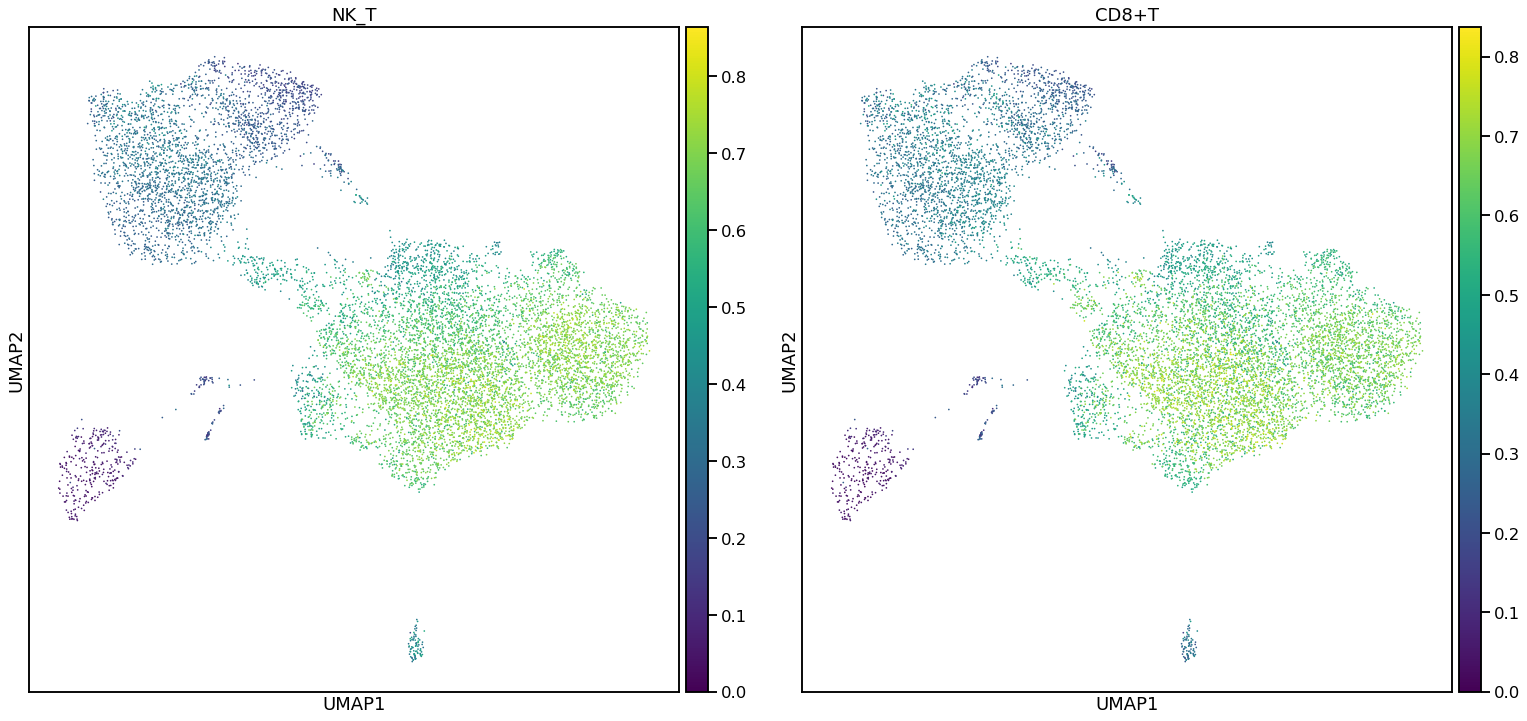

In [631]:
sc.pl.umap(ato_adata, color=['NK_T','CD8+T'], vmin=0, cmap='viridis')

In [645]:
df = ato_adata.obs[['NK_T','TH17']]

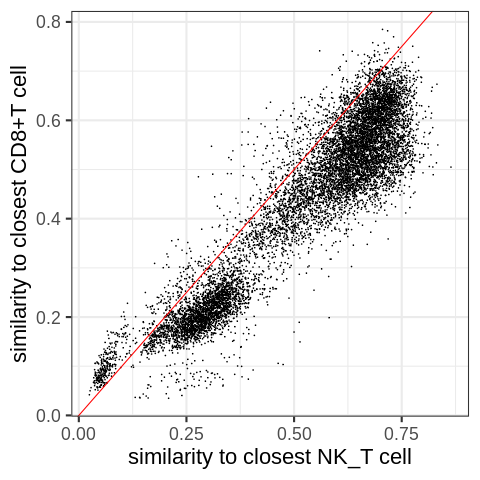

In [647]:
%%R -i df

df %>%
 ggplot(aes(NK_T, TH17)) +
    geom_point(size=0.1) +
    geom_abline(color='red') +
#     xlim(0.4,1) + ylim(0.4,1) +
    theme_bw(base_size=22) +
    xlab('similarity to closest NK_T cell') +
    ylab('similarity to closest CD8+T cell') 

... storing 'closest_cell' as categorical


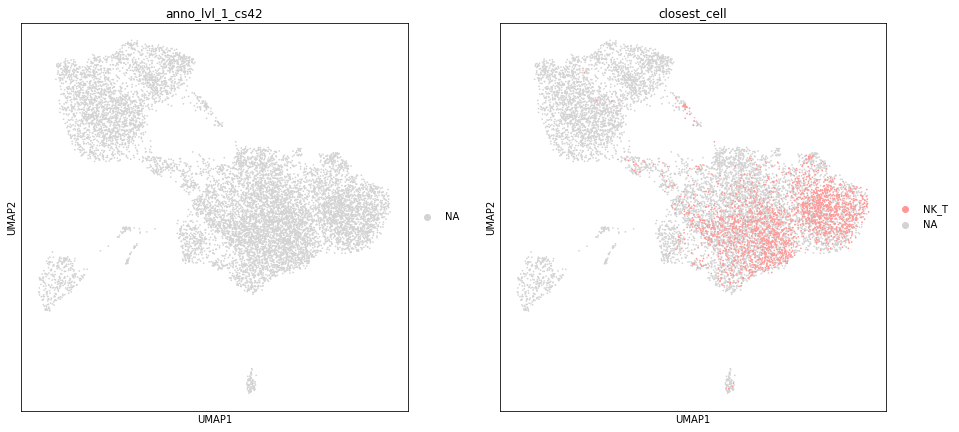

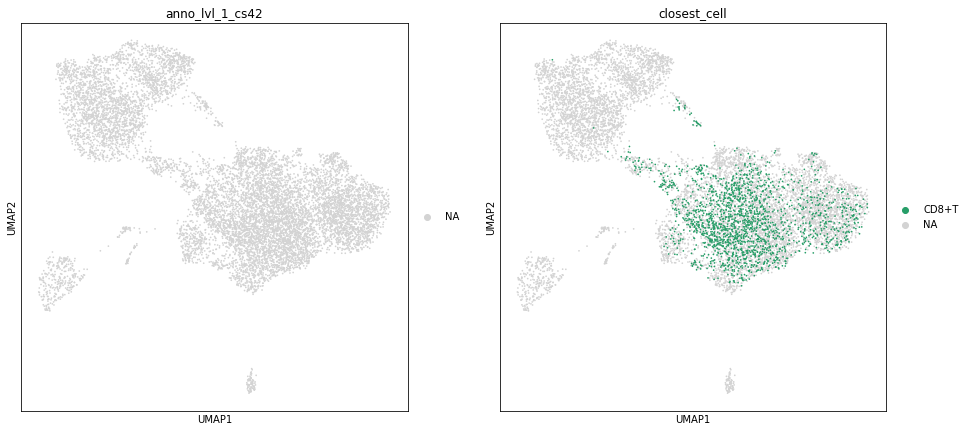

In [558]:
sc.pl.umap(ato_adata, color=['anno_lvl_1_cs42','closest_cell'], groups=["NK_T"])
sc.pl.umap(ato_adata, color=['anno_lvl_1_cs42','closest_cell'], groups=["CD8+T"])

In [397]:
%%R -i ct_distances_df
ct_distances_df %>%
    select(cell_barcode) %>%
    

cell_barcode    0     AAACCTGAGGCGACAT-1_6180STDY9448808-query
                1     AAACCTGCAATCCAAC-1_6180STDY9448808-query
                2     AAACCTGCATCACGTA-1_6180STDY9448808-query
                3     AAAGCAAAGGATGGAA-1_6180STDY9448808-query
                4     AAAGCAATCGCGCCAA-1_6180STDY9448808-query
                                        ...                   
ref_population  72                                     DN(Q)_T
                73                                     DN(Q)_T
                74                                     DN(Q)_T
                75                                     DN(Q)_T
                76                                     DN(Q)_T
Length: 470655, dtype: object

In [218]:
q_obs='leiden'

keep_invitro_cells_names = ato_adata.obs_names[ato_adata.obs[q_obs].isin(keep_leiden)] + "-query"
sim_df = pd.DataFrame(merged_adata.obs.loc[keep_invitro_cells_names,'knn_sim'].values)
sim_df.columns = ['knn_similarity']

ref_pops = ['NK_T', "CD4+T", "TH17", "NK", "CD8+T", "MATURE_B"]
for r_cl in ref_pops:
    d1 = _compute_invivoVSinvitro_distance(merged_adata, q_cl=keep_leiden, r_cl=r_cl)
    sim_df["similarity_"+r_cl] = d1
sim_df = sim_df.drop('knn_similarity', 1)

In [219]:
sim_df_long = sim_df.stack().reset_index()
sim_df_long.columns = ['level_0', 'ref_pop', 'min_distance']

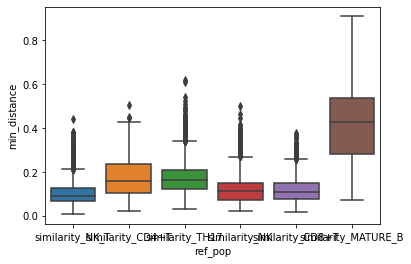

In [220]:
sns.boxplot(data=sim_df_long, y='min_distance', x='ref_pop');

In [221]:
keep_leiden = ato_adata.obs['leiden'][ato_adata.obs['anno_lvl_2_cs42'].str.contains("DP", na=False)].value_counts()[0:10].index

In [226]:
q_obs='leiden'

keep_invitro_cells_names = ato_adata.obs_names[ato_adata.obs[q_obs].isin(keep_leiden)] + "-query"
sim_df = pd.DataFrame(merged_adata.obs.loc[keep_invitro_cells_names,'knn_sim'].values)
sim_df.columns = ['knn_similarity']

for r_cl in ref_pops:
    d1 = _compute_invivoVSinvitro_distance(merged_adata, q_cl=keep_leiden, r_cl=r_cl)
    sim_df["similarity_"+r_cl] = d1
sim_df = sim_df.drop('knn_similarity', 1)

In [231]:
merged_adata.obs['annotation_query'] 

FCAImmP7579224-CTAATGGCACTGTGTA-reference       nan
FCAImmP7579224-ATTATCCAGAGAACAG-reference       nan
FCAImmP7579224-GACGGCTAGCCACCTG-reference       nan
FCAImmP7579224-GCGGGTTGTCCGAGTC-reference       nan
FCAImmP7579224-AGTTGGTAGTGTTAGA-reference       nan
                                              ...  
TTTGTCACAGGAATCG-1_6180STDY9448813-query      3-NKT
TTTGTCACAGGGTACA-1_6180STDY9448813-query     15-NKT
TTTGTCAGTAGCACGA-1_6180STDY9448813-query      3-NKT
TTTGTCAGTAGTGAAT-1_6180STDY9448813-query       7-DP
TTTGTCATCGGATGTT-1_6180STDY9448813-query       7-DP
Name: annotation_query, Length: 250157, dtype: category
Categories (31, object): ['0-NKT', '1-NKT', '2-DN/DP', '3-NKT', ..., '20-ILC', '20-NKT', '21-DP', 'nan']

In [227]:
sim_df_long = sim_df.stack().reset_index()
sim_df_long.columns = ['level_0', 'ref_pop', 'min_distance']

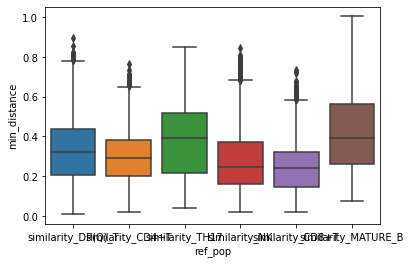

In [228]:
sns.boxplot(data=sim_df_long, y='min_distance', x='ref_pop');

## Map to NKT model

In [569]:
python ./run_map_query.py /home/jupyter/mount/gdrive/Pan_fetal/data4gpu_node/ATO_query.h5ad NKT ATO_immune 

array(['ENSG00000000938', 'ENSG00000000971', 'ENSG00000001630', ...,
       'ENSG00000285486', 'ENSG00000285492', 'ENSG00000285513'],
      dtype=object)

### Load output

In [612]:
data_dir = '/nfs/team205/ed6/data/Fetal_immune/'

merged_adata_file = 'ATO_query.mapped2NKT.withReference.h5ad'
split = "NKT"
ref_data_dir = '/home/jovyan/mount/gdrive/Pan_fetal/data4gpu_node/'
timestamp = '20210429'

In [613]:
merged_adata_2 = sc.read_h5ad(ref_data_dir + merged_adata_file)

In [313]:
# merged_adata = merged_adata_2.copy()

In [614]:
## Filter maternal contaminants
mat_barcodes = pd.read_csv("~/Pan_fetal_immune/metadata/souporcell_results/maternal_barcodes.csv", index_col=0)
mat_barcodes = pd.Series([x.split("-1")[0] for x in mat_barcodes['x']])
reference_obs = merged_adata_2.obs_names[merged_adata_2.obs.dataset == "reference"]
exclude_obs = reference_obs[reference_obs.str.strip("-reference").isin(mat_barcodes)]

merged_adata_2 = merged_adata_2[~merged_adata_2.obs_names.isin(exclude_obs)].copy()

In [616]:
## Add metadata and annotations for the reference
anno_obs = pd.read_csv(data_dir + "PAN.A01.v01.entire_data_normalised_log.20210429.full_obs.annotated.clean.csv", index_col=0)

## Read annotation groupings
import json
with open('../../metadata/anno_groups.json', 'r') as json_file:
    anno_groups_dict = json.load(json_file)
    
reference_obs = merged_adata_2.obs_names[merged_adata_2.obs.dataset == "reference"]

merged_adata_2.obs["annotation_reference"] = np.nan
merged_adata_2.obs.loc[reference_obs, "annotation_reference"] = anno_obs.loc[reference_obs.str.strip("-reference")]["anno_lvl_2_final_clean"].values

merged_adata_2.obs["organ"] = np.nan
merged_adata_2.obs.loc[reference_obs, "organ"] = anno_obs.loc[reference_obs.str.strip("-reference")]["organ"].values
merged_adata_2.obs["age"] = np.nan
merged_adata_2.obs.loc[reference_obs, "age"] = anno_obs.loc[reference_obs.str.strip("-reference")]["age"].values

In [617]:
## Add metadata and annotations for the query
query_obs = merged_adata_2.obs_names[merged_adata_2.obs.dataset == "query"]
merged_adata_2.obs["annotation_query"] = ato_adata.obs["anno_lvl_1_cs42"]

... storing 'annotation_reference' as categorical
... storing 'organ' as categorical


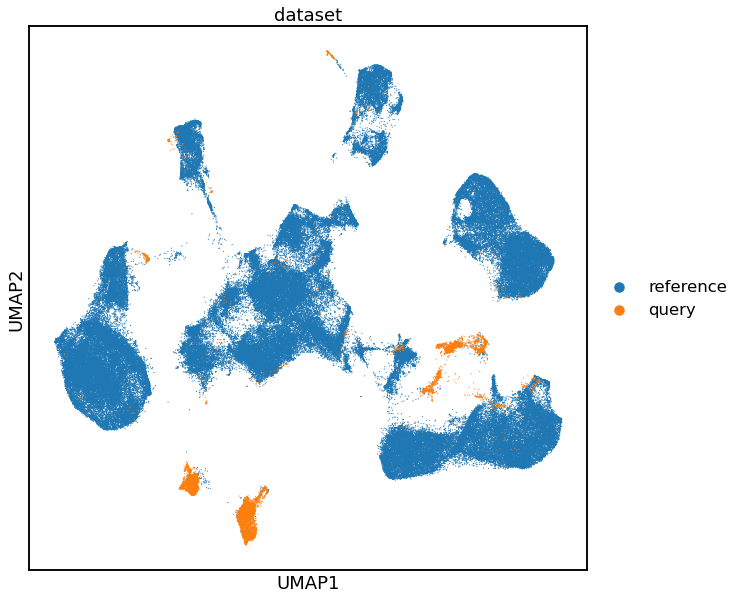

In [619]:
plt.rcParams["figure.figsize"] = [10,10]
sc.pl.umap(merged_adata_2, color=["dataset"], size=5)

### Plot query and reference annotations

In [620]:
plt.rcParams['figure.figsize'] = [12,12]
anno_labels = merged_adata_2.obs["annotation_query"][~merged_adata.obs["annotation_query"].isna()].unique().tolist()
anno_labels

['ERY', 'DN/DP', 'ILC3', 'NK', 'HIGH_MITO', 'ABT(ENTRY)', 'SP_T', 'MAST CELL']

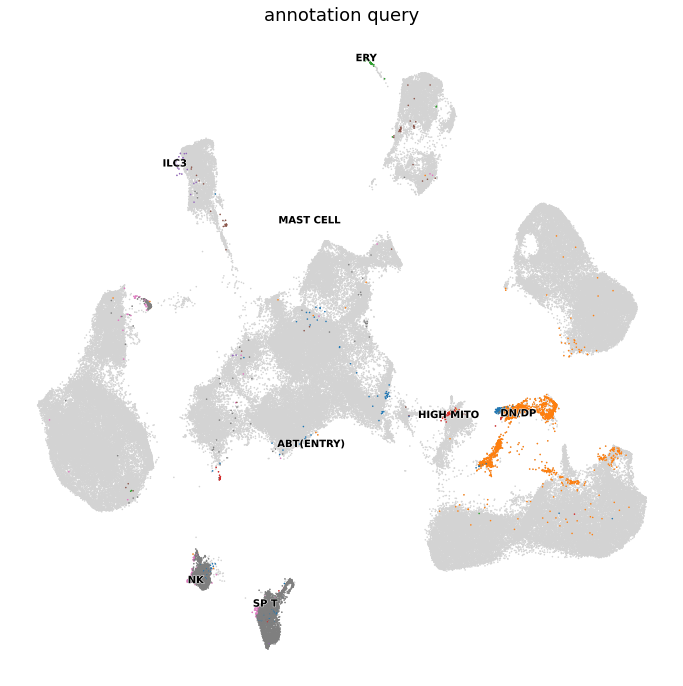

In [621]:
scv.pl.umap(merged_adata_2, color=["annotation_query"], size=10, legend_loc="on data", groups=anno_labels, title="annotation query", legend_fontsize=10, 
#             save="anno_query_lymphoid.png"
           )

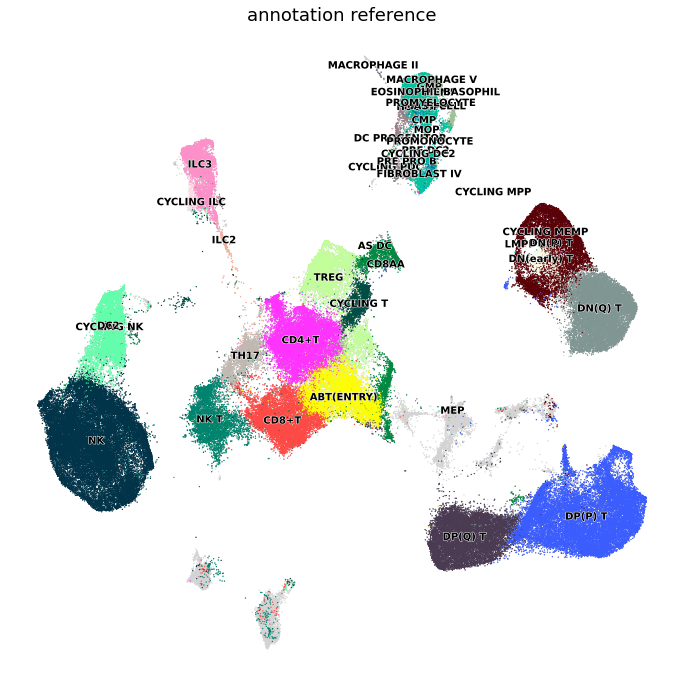

In [622]:
anno_labels = merged_adata_2.obs["annotation_reference"][merged_adata_2.obs["annotation_reference"]!="nan"].unique().tolist()
anno_labels = [x for x in anno_labels if type(x)==str]
anno_labels = [x for x in anno_labels if x not in anno_groups_dict["OTHER"]]

scv.pl.umap(merged_adata_2, color=["annotation_reference"], size=7, legend_loc="on data", groups=anno_labels, 
            legend_fontsize=10,
            title="annotation reference",
#            save="anno_reference_lymphoid.png"
           )